In [1]:
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
import scipy.sparse as sp
from scipy.sparse import load_npz, save_npz
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, average_precision_score
import time
from netgan import netgan
import sys
sys.path.insert(0, '../src/')
import utils

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hheidrich/miniconda3/envs/ne

#### Load the data

In [2]:
dataset = 'polblogs'
#dataset = 'rt_gop'
#dataset = 'web_edu'
#dataset = "citeseer"
#dataset = "CORA_ML"
data_path = f'../data/datasets/{dataset}.npz'
_A_obs = load_npz(data_path)
_N = _A_obs.shape[0]

In [3]:
# remove weights
_A_obs = 1.* (_A_obs > 0)

In [4]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [5]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

## Logs

In [6]:
def save_netgan_logs(log_dict, path, num_edges):
    
    overlaps = {i+1:overlap for i, overlap in enumerate(np.array(log_dict['edge_overlaps'])/num_edges)}
    timings = {i+1: timing for i, timing in enumerate(log_dict['times'])}
    
    val_perfs = np.array(log_dict['val_performances'])
    roc_aucs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,0])}
    avg_precs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,1])}
    
    dcts = {'overlap': overlaps,
            'timing': timings,
            'ROC-AUC': roc_aucs,
            'avg_prec': avg_precs,}
    
    str_len = len(str(len(log_dict['generated_graphs'])))
    Path(path).mkdir(parents=True, exist_ok=True)
    for name, dct in dcts.items():
        utils.save_dict(dct, os.path.join(path, f'{name}.pickle'))
    for i, graph in enumerate(log_dict['generated_graphs']):
        save_npz(matrix=sp.csr_matrix(graph), file=os.path.join(path, f'graph_{i+1:0{str_len}d}'))

In [7]:
def run_multiple_netgan_experiments(num_experiments,
                                    log_path,
                                    train_graph,
                                    val_ones,
                                    val_zeros,
                                    max_iters=200000,
                                    eval_every=2000,
                                    plot_every=2000,
                                    rw_len=16,
                                    batch_size=128):
    str_len = len(str(num_experiments-1))
    walker = netgan.utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)
    for i in range(num_experiments):
        # create model
        model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
        # train model
        log_dict = model.train(A_orig=train_graph, val_ones=val_ones, val_zeros=val_zeros, stopping=1.0,
                               eval_every=eval_every, plot_every=plot_every, max_patience=20,
                               max_iters=max_iters)
        
        # save logs
        save_netgan_logs(log_dict=log_dict,
                         path=os.path.join(log_path, f'Experiment_{i:0{str_len}d}/sampled_graphs/'),
                         num_edges=train_graph.sum())
        
        # close session
        model.session.close()
        # reset graph
        tf.reset_default_graph()

In [8]:
run_multiple_netgan_experiments(num_experiments=5,
                                log_path='../logs/citeseer/baseline_NetGan/',
                                train_graph=train_graph,
                                val_ones=val_ones,
                                val_zeros=val_zeros,
                                max_iters=200000)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


KeyboardInterrupt: 

## Training

In [7]:
def train_to_eo_and_save_models(target_eo,
                                num_models,
                                dataset,
                                train_graph,
                                val_ones,
                                val_zeros,
                                max_iters=200000,
                                eval_every=2000,
                                plot_every=2000,
                                rw_len=16,
                                batch_size=128):
    str_len = len(str(num_models-1))
    directory = os.path.join('../models',
                             dataset,
                             f'netgan_eo_{int(100*target_eo)}')
    Path(directory).mkdir(parents=True, exist_ok=True)
    
    walker = netgan.utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)
                                 
    for i in range(num_models):
        
        # create model
        model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
        # train model
        log_dict = model.train(A_orig=train_graph, val_ones=val_ones, val_zeros=val_zeros,
                               stopping=target_eo, eval_every=eval_every, plot_every=plot_every, max_patience=20,
                               max_iters=max_iters)
        
        # save timings
        utils.save_dict(log_dict['times'], os.path.join(directory, f'timings_{i:0{str_len}d}.pickle'))
        
        #save_model
        saver = tf.train.Saver()
        _ = saver.save(model.session, os.path.join(directory, f'model_{i:0{str_len}d}.ckpt'))
        # close session
        model.session.close()
        # reset graph
        tf.reset_default_graph()




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
**** Using EO criterion of 0.52 for early stopping
**** Saving snapshots into ../snapshots/model_best_60.ckpt ****
**** Initializing... ****
**** Done.           ****



**** Starting training. ****


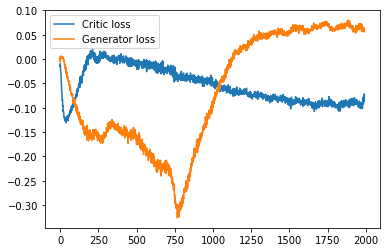

**** Iter 2000   Val ROC 0.912, AP: 0.900, EO 0.119 ****
2500   /200000   training iterations, took 854 seconds so far...


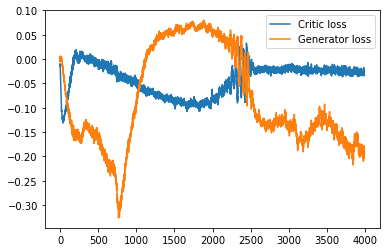

**** Iter 4000   Val ROC 0.948, AP: 0.941, EO 0.205 ****
5000   /200000   training iterations, took 1696 seconds so far...


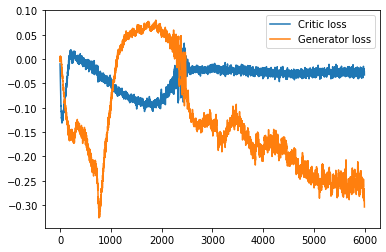

**** Iter 6000   Val ROC 0.949, AP: 0.948, EO 0.239 ****
7500   /200000   training iterations, took 2540 seconds so far...


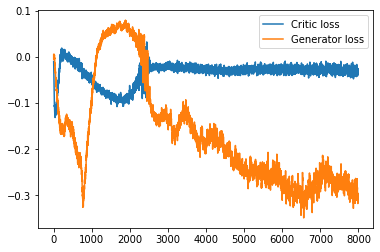

**** Iter 8000   Val ROC 0.951, AP: 0.949, EO 0.263 ****


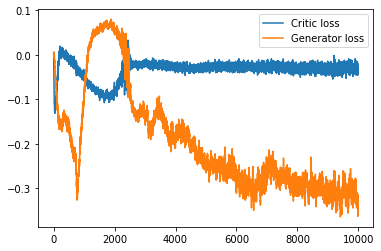

10000  /200000   training iterations, took 3380 seconds so far...
**** Iter 10000  Val ROC 0.950, AP: 0.949, EO 0.277 ****


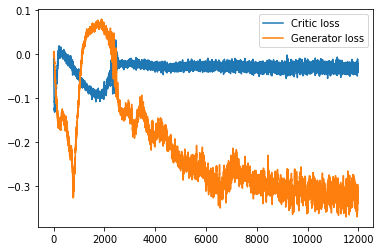

**** Iter 12000  Val ROC 0.950, AP: 0.947, EO 0.306 ****
12500  /200000   training iterations, took 4239 seconds so far...


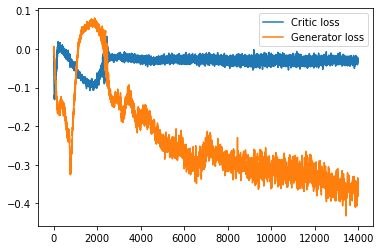

**** Iter 14000  Val ROC 0.948, AP: 0.943, EO 0.319 ****
15000  /200000   training iterations, took 5081 seconds so far...


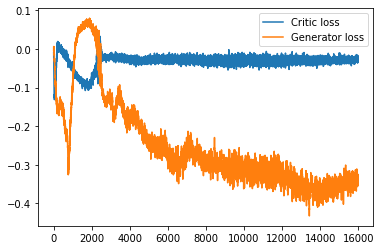

**** Iter 16000  Val ROC 0.945, AP: 0.938, EO 0.334 ****
17500  /200000   training iterations, took 5925 seconds so far...


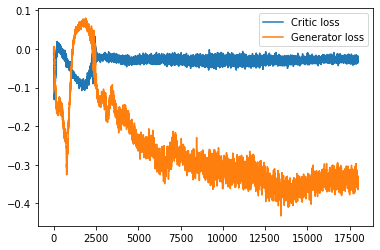

**** Iter 18000  Val ROC 0.942, AP: 0.933, EO 0.350 ****


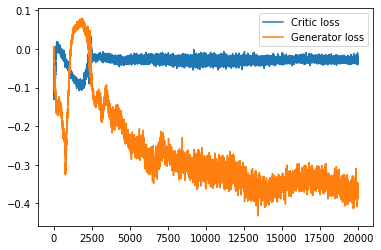

20000  /200000   training iterations, took 6768 seconds so far...
**** Iter 20000  Val ROC 0.943, AP: 0.937, EO 0.359 ****


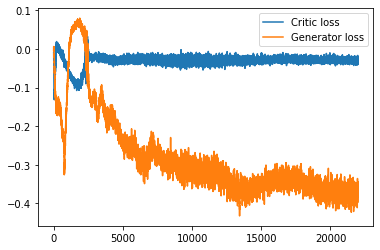

**** Iter 22000  Val ROC 0.943, AP: 0.938, EO 0.379 ****
22500  /200000   training iterations, took 7631 seconds so far...


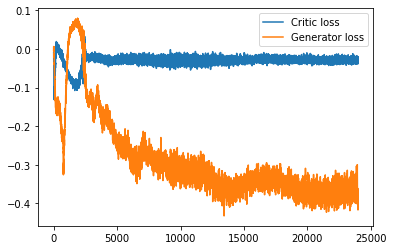

**** Iter 24000  Val ROC 0.937, AP: 0.934, EO 0.407 ****
25000  /200000   training iterations, took 8477 seconds so far...


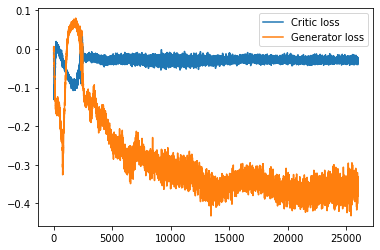

**** Iter 26000  Val ROC 0.939, AP: 0.934, EO 0.426 ****
27500  /200000   training iterations, took 9324 seconds so far...


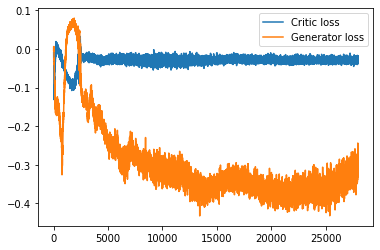

**** Iter 28000  Val ROC 0.936, AP: 0.929, EO 0.436 ****


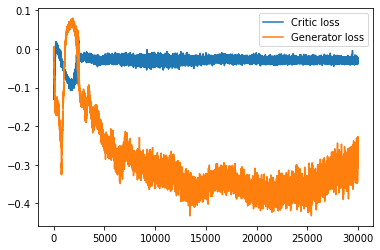

30000  /200000   training iterations, took 10168 seconds so far...
**** Iter 30000  Val ROC 0.933, AP: 0.926, EO 0.442 ****


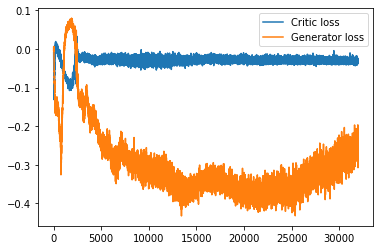

**** Iter 32000  Val ROC 0.933, AP: 0.928, EO 0.457 ****
32500  /200000   training iterations, took 11027 seconds so far...


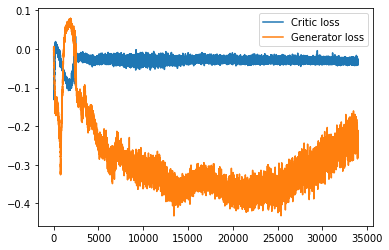

**** Iter 34000  Val ROC 0.934, AP: 0.929, EO 0.461 ****
35000  /200000   training iterations, took 11869 seconds so far...


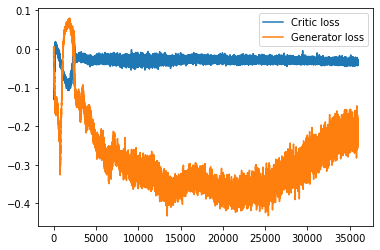

**** Iter 36000  Val ROC 0.933, AP: 0.927, EO 0.465 ****
37500  /200000   training iterations, took 12712 seconds so far...


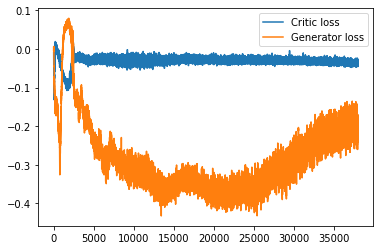

**** Iter 38000  Val ROC 0.935, AP: 0.929, EO 0.475 ****


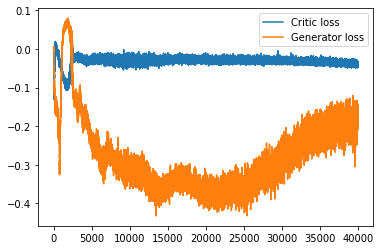

40000  /200000   training iterations, took 13555 seconds so far...
**** Iter 40000  Val ROC 0.935, AP: 0.931, EO 0.480 ****


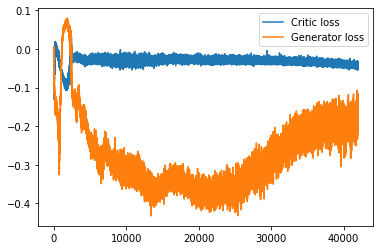

**** Iter 42000  Val ROC 0.937, AP: 0.933, EO 0.481 ****
42500  /200000   training iterations, took 14414 seconds so far...


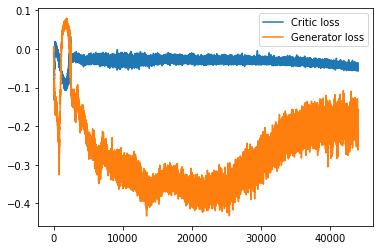

**** Iter 44000  Val ROC 0.938, AP: 0.933, EO 0.481 ****
45000  /200000   training iterations, took 15258 seconds so far...


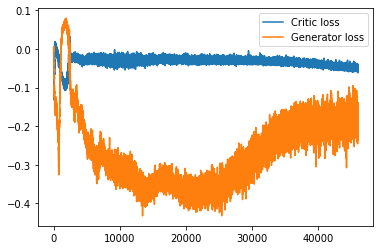

**** Iter 46000  Val ROC 0.940, AP: 0.935, EO 0.486 ****
47500  /200000   training iterations, took 16103 seconds so far...


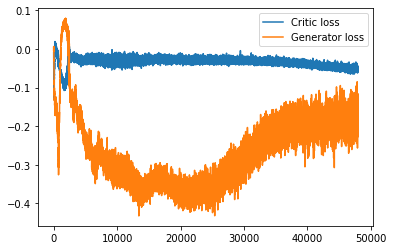

**** Iter 48000  Val ROC 0.939, AP: 0.935, EO 0.478 ****


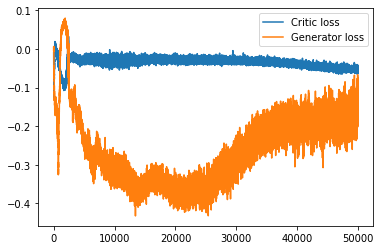

50000  /200000   training iterations, took 16946 seconds so far...
**** Iter 50000  Val ROC 0.939, AP: 0.935, EO 0.489 ****


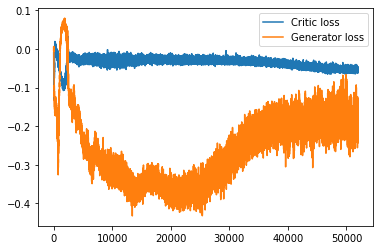

**** Iter 52000  Val ROC 0.940, AP: 0.937, EO 0.479 ****
52500  /200000   training iterations, took 17809 seconds so far...


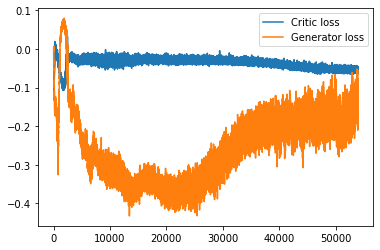

**** Iter 54000  Val ROC 0.941, AP: 0.937, EO 0.485 ****
55000  /200000   training iterations, took 18655 seconds so far...


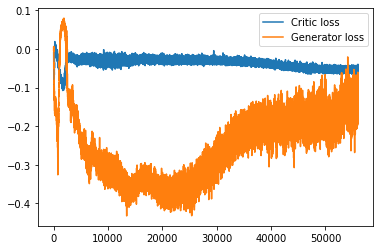

**** Iter 56000  Val ROC 0.942, AP: 0.938, EO 0.483 ****
57500  /200000   training iterations, took 19498 seconds so far...


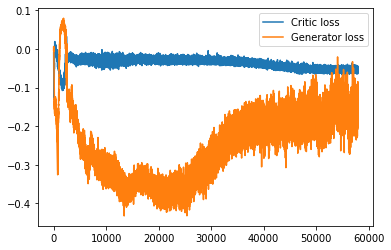

**** Iter 58000  Val ROC 0.940, AP: 0.937, EO 0.491 ****


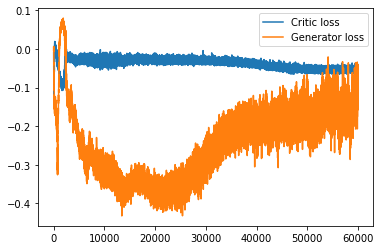

60000  /200000   training iterations, took 20342 seconds so far...
**** Iter 60000  Val ROC 0.939, AP: 0.936, EO 0.493 ****


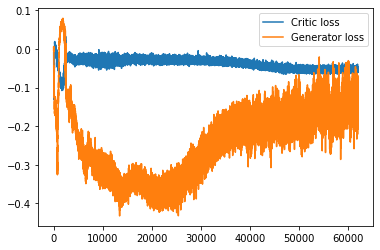

**** Iter 62000  Val ROC 0.939, AP: 0.937, EO 0.486 ****
62500  /200000   training iterations, took 21201 seconds so far...


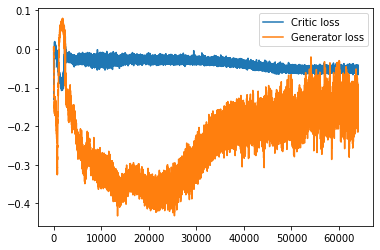

**** Iter 64000  Val ROC 0.939, AP: 0.935, EO 0.485 ****
65000  /200000   training iterations, took 22042 seconds so far...


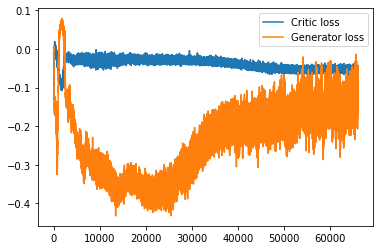

**** Iter 66000  Val ROC 0.940, AP: 0.936, EO 0.493 ****
67500  /200000   training iterations, took 22886 seconds so far...


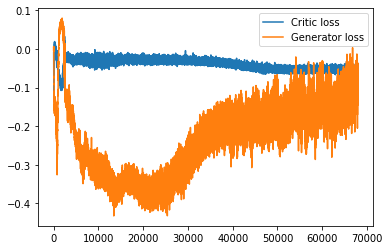

**** Iter 68000  Val ROC 0.941, AP: 0.937, EO 0.490 ****


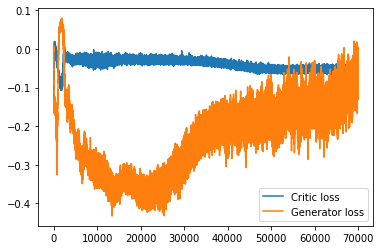

70000  /200000   training iterations, took 23729 seconds so far...
**** Iter 70000  Val ROC 0.941, AP: 0.937, EO 0.487 ****


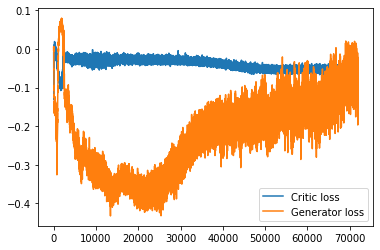

**** Iter 72000  Val ROC 0.940, AP: 0.937, EO 0.492 ****
72500  /200000   training iterations, took 24588 seconds so far...


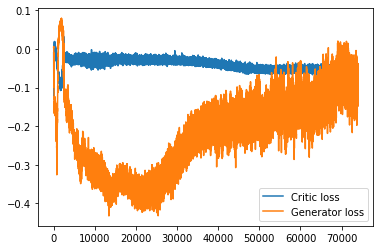

**** Iter 74000  Val ROC 0.941, AP: 0.936, EO 0.495 ****
75000  /200000   training iterations, took 25432 seconds so far...


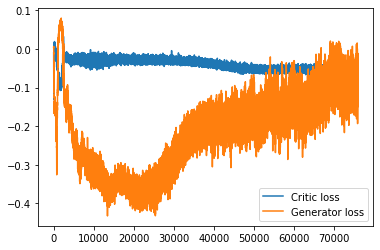

**** Iter 76000  Val ROC 0.941, AP: 0.938, EO 0.492 ****
77500  /200000   training iterations, took 26275 seconds so far...


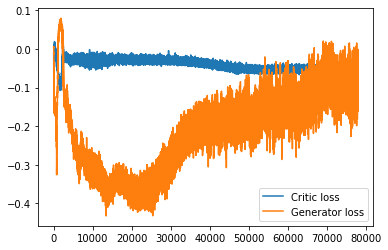

**** Iter 78000  Val ROC 0.941, AP: 0.936, EO 0.493 ****


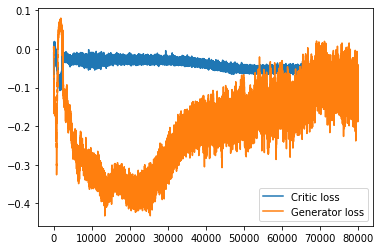

80000  /200000   training iterations, took 27119 seconds so far...
**** Iter 80000  Val ROC 0.941, AP: 0.937, EO 0.496 ****


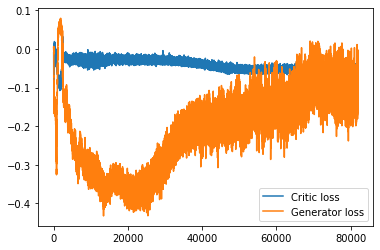

**** Iter 82000  Val ROC 0.939, AP: 0.935, EO 0.496 ****
82500  /200000   training iterations, took 27977 seconds so far...


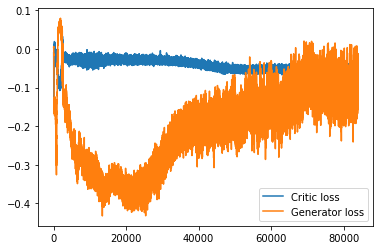

**** Iter 84000  Val ROC 0.937, AP: 0.934, EO 0.490 ****
85000  /200000   training iterations, took 28818 seconds so far...


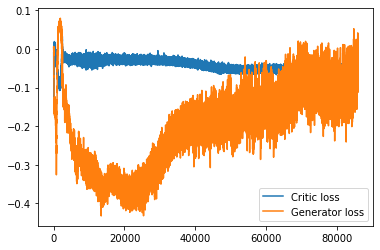

**** Iter 86000  Val ROC 0.939, AP: 0.936, EO 0.499 ****
87500  /200000   training iterations, took 29657 seconds so far...


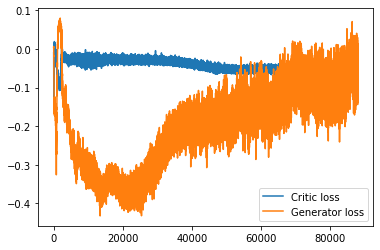

**** Iter 88000  Val ROC 0.940, AP: 0.937, EO 0.497 ****


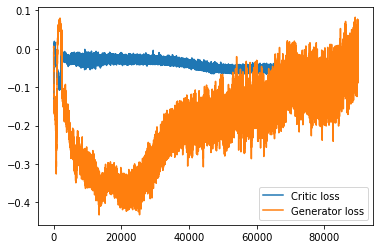

90000  /200000   training iterations, took 30494 seconds so far...
**** Iter 90000  Val ROC 0.937, AP: 0.934, EO 0.485 ****


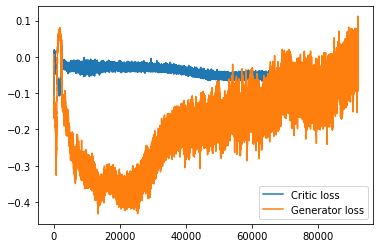

**** Iter 92000  Val ROC 0.940, AP: 0.935, EO 0.496 ****
92500  /200000   training iterations, took 31347 seconds so far...


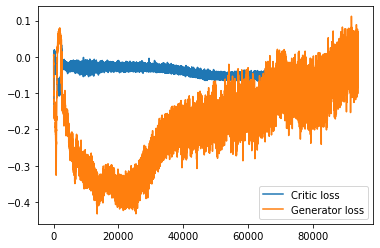

**** Iter 94000  Val ROC 0.940, AP: 0.937, EO 0.497 ****
95000  /200000   training iterations, took 32184 seconds so far...


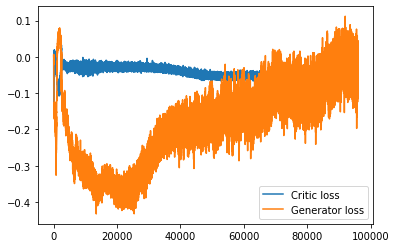

**** Iter 96000  Val ROC 0.941, AP: 0.938, EO 0.497 ****
97500  /200000   training iterations, took 33021 seconds so far...


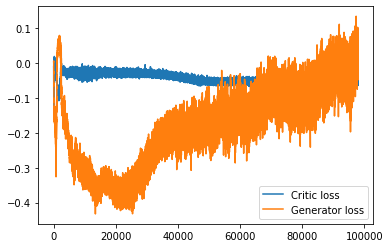

**** Iter 98000  Val ROC 0.940, AP: 0.938, EO 0.503 ****


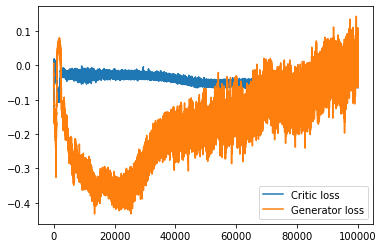

100000 /200000   training iterations, took 33858 seconds so far...
**** Iter 100000 Val ROC 0.940, AP: 0.938, EO 0.497 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


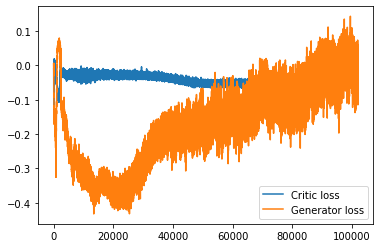

**** Iter 102000 Val ROC 0.940, AP: 0.938, EO 0.500 ****
102500 /200000   training iterations, took 34714 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


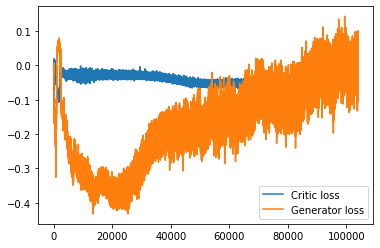

**** Iter 104000 Val ROC 0.941, AP: 0.938, EO 0.501 ****
105000 /200000   training iterations, took 35552 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


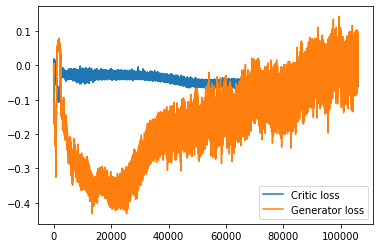

**** Iter 106000 Val ROC 0.942, AP: 0.939, EO 0.499 ****
107500 /200000   training iterations, took 36391 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


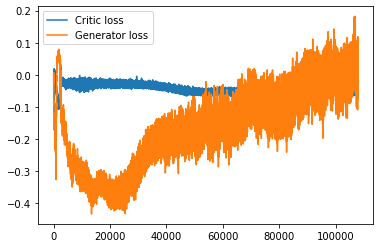

**** Iter 108000 Val ROC 0.938, AP: 0.936, EO 0.500 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


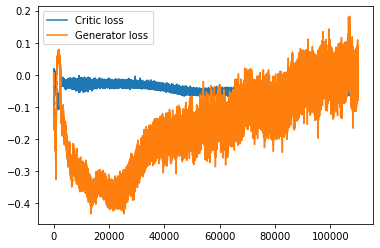

110000 /200000   training iterations, took 37229 seconds so far...
**** Iter 110000 Val ROC 0.939, AP: 0.938, EO 0.498 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


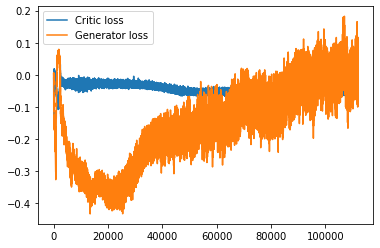

**** Iter 112000 Val ROC 0.941, AP: 0.937, EO 0.504 ****
112500 /200000   training iterations, took 38082 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


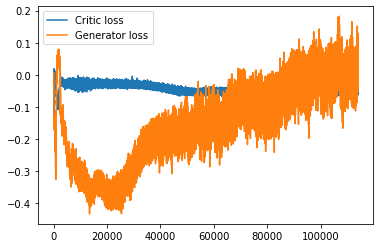

**** Iter 114000 Val ROC 0.943, AP: 0.939, EO 0.511 ****
115000 /200000   training iterations, took 38922 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


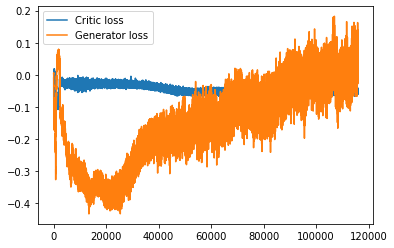

**** Iter 116000 Val ROC 0.939, AP: 0.938, EO 0.497 ****
117500 /200000   training iterations, took 39758 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


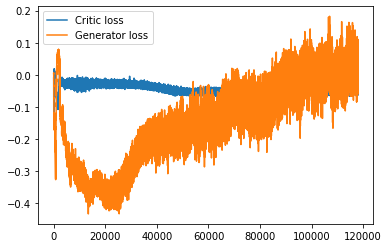

**** Iter 118000 Val ROC 0.940, AP: 0.939, EO 0.498 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


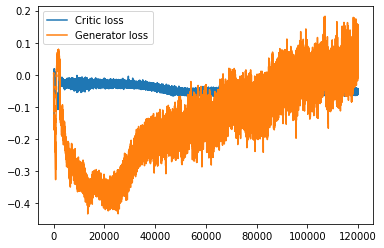

120000 /200000   training iterations, took 40595 seconds so far...
**** Iter 120000 Val ROC 0.941, AP: 0.938, EO 0.501 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


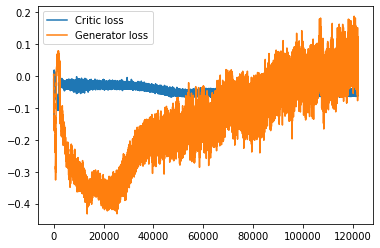

**** Iter 122000 Val ROC 0.940, AP: 0.939, EO 0.501 ****
122500 /200000   training iterations, took 41446 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


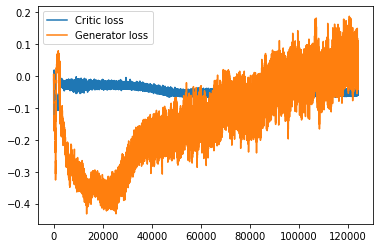

**** Iter 124000 Val ROC 0.941, AP: 0.939, EO 0.501 ****
125000 /200000   training iterations, took 42282 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


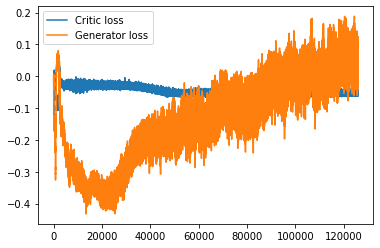

**** Iter 126000 Val ROC 0.942, AP: 0.940, EO 0.502 ****
127500 /200000   training iterations, took 43123 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


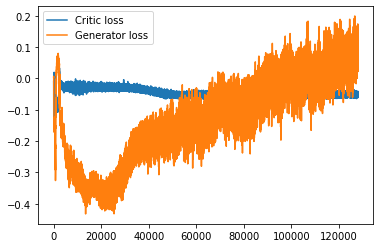

**** Iter 128000 Val ROC 0.942, AP: 0.939, EO 0.502 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


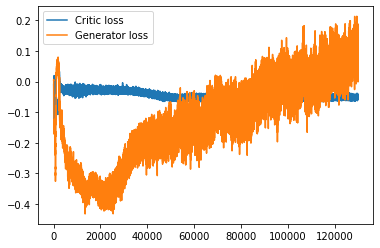

130000 /200000   training iterations, took 43963 seconds so far...
**** Iter 130000 Val ROC 0.943, AP: 0.940, EO 0.511 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


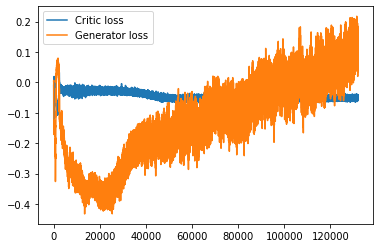

**** Iter 132000 Val ROC 0.943, AP: 0.939, EO 0.502 ****
132500 /200000   training iterations, took 44817 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


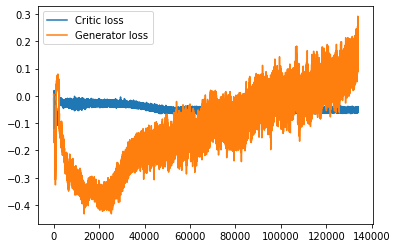

**** Iter 134000 Val ROC 0.940, AP: 0.937, EO 0.503 ****
135000 /200000   training iterations, took 45658 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


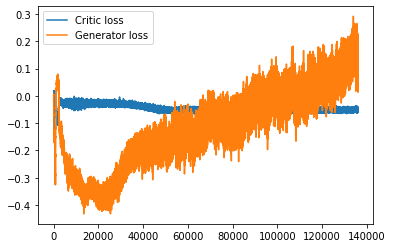

**** Iter 136000 Val ROC 0.943, AP: 0.940, EO 0.504 ****
137500 /200000   training iterations, took 46496 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


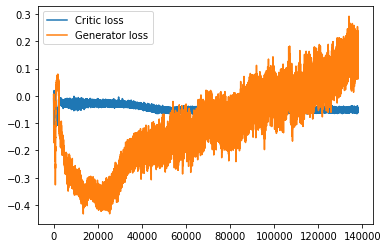

**** Iter 138000 Val ROC 0.940, AP: 0.939, EO 0.505 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


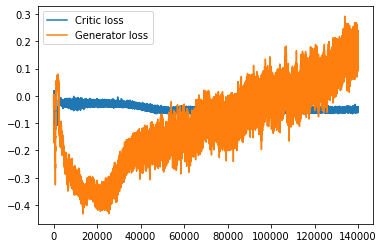

140000 /200000   training iterations, took 47337 seconds so far...
**** Iter 140000 Val ROC 0.942, AP: 0.940, EO 0.507 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


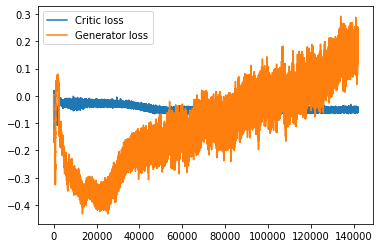

**** Iter 142000 Val ROC 0.941, AP: 0.938, EO 0.505 ****
142500 /200000   training iterations, took 48191 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


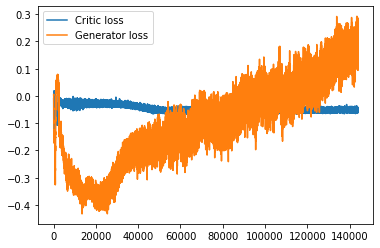

**** Iter 144000 Val ROC 0.942, AP: 0.940, EO 0.507 ****
145000 /200000   training iterations, took 49033 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


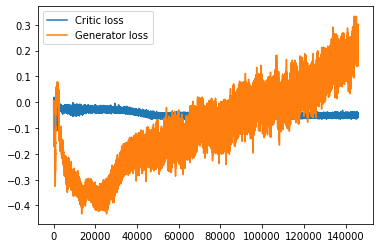

**** Iter 146000 Val ROC 0.941, AP: 0.940, EO 0.512 ****
147500 /200000   training iterations, took 49876 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


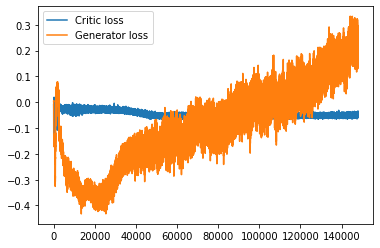

**** Iter 148000 Val ROC 0.942, AP: 0.940, EO 0.507 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


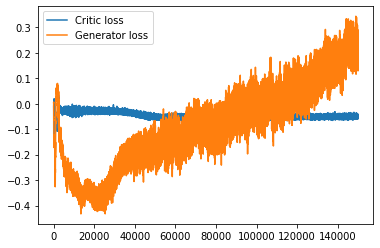

150000 /200000   training iterations, took 50720 seconds so far...
**** Iter 150000 Val ROC 0.940, AP: 0.938, EO 0.508 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


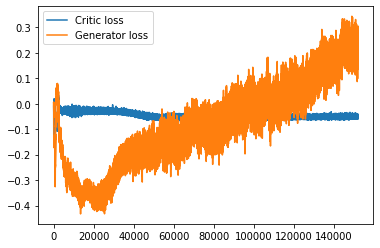

**** Iter 152000 Val ROC 0.942, AP: 0.939, EO 0.515 ****
152500 /200000   training iterations, took 51581 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


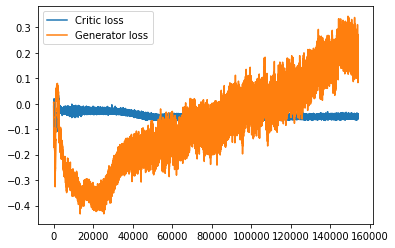

**** Iter 154000 Val ROC 0.941, AP: 0.940, EO 0.511 ****
155000 /200000   training iterations, took 52421 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


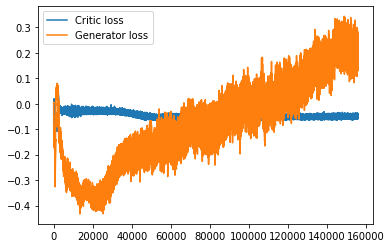

**** Iter 156000 Val ROC 0.943, AP: 0.940, EO 0.515 ****
157500 /200000   training iterations, took 53264 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


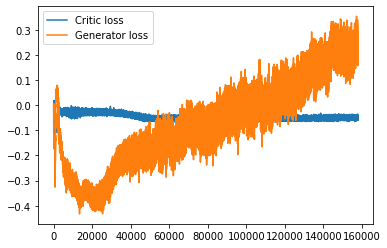

**** Iter 158000 Val ROC 0.941, AP: 0.940, EO 0.505 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


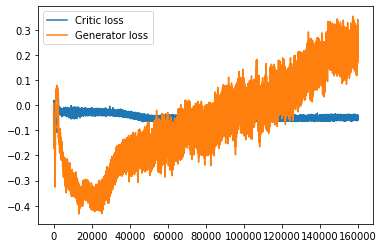

160000 /200000   training iterations, took 54107 seconds so far...
**** Iter 160000 Val ROC 0.939, AP: 0.937, EO 0.511 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


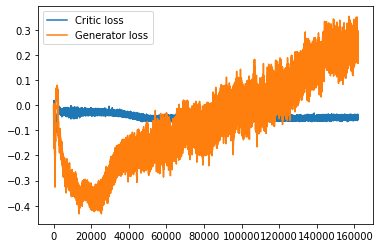

**** Iter 162000 Val ROC 0.942, AP: 0.940, EO 0.507 ****
162500 /200000   training iterations, took 54967 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


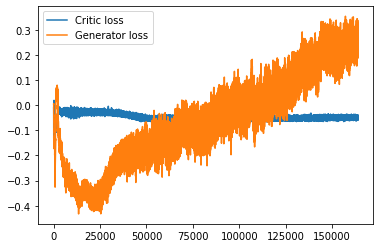

**** Iter 164000 Val ROC 0.943, AP: 0.942, EO 0.510 ****
165000 /200000   training iterations, took 55810 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


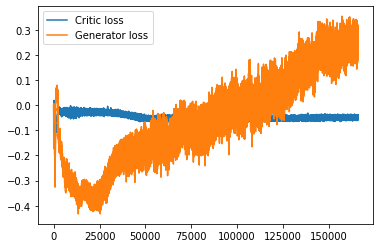

**** Iter 166000 Val ROC 0.943, AP: 0.941, EO 0.516 ****
167500 /200000   training iterations, took 56655 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


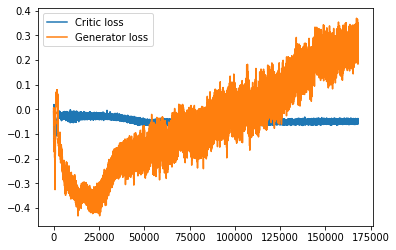

**** Iter 168000 Val ROC 0.940, AP: 0.938, EO 0.511 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


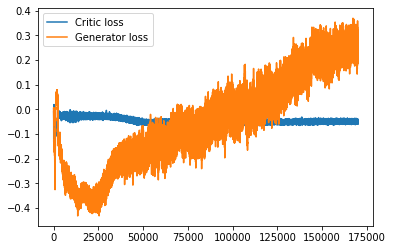

170000 /200000   training iterations, took 57500 seconds so far...
**** Iter 170000 Val ROC 0.942, AP: 0.939, EO 0.510 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


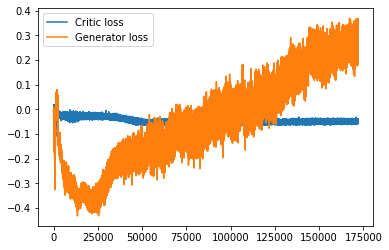

**** Iter 172000 Val ROC 0.941, AP: 0.938, EO 0.510 ****
172500 /200000   training iterations, took 58362 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


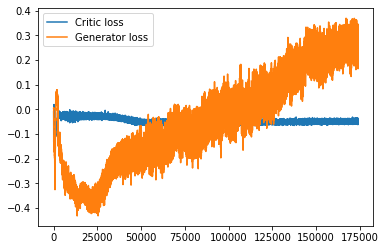

**** Iter 174000 Val ROC 0.940, AP: 0.938, EO 0.520 ****
175000 /200000   training iterations, took 59204 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


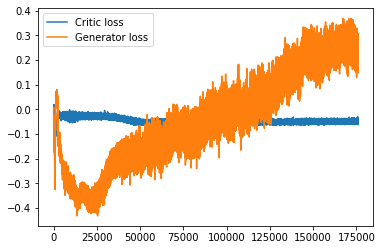

**** Iter 176000 Val ROC 0.941, AP: 0.938, EO 0.514 ****
177500 /200000   training iterations, took 60048 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


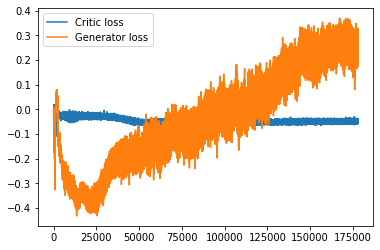

**** Iter 178000 Val ROC 0.941, AP: 0.938, EO 0.514 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


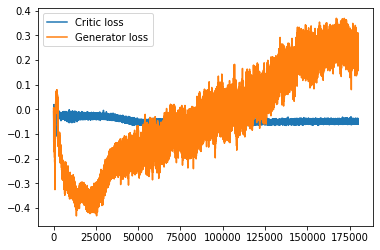

180000 /200000   training iterations, took 60894 seconds so far...
**** Iter 180000 Val ROC 0.942, AP: 0.939, EO 0.522 ****
**** EARLY STOPPING AFTER 180000 ITERATIONS ****
**** Training completed after 180000 iterations. ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


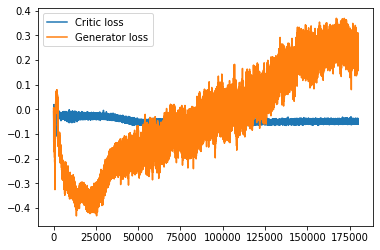

**** Using EO criterion of 0.52 for early stopping
**** Saving snapshots into ../snapshots/model_best_61.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****


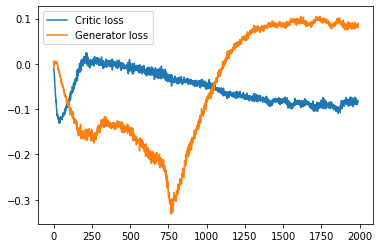

**** Iter 2000   Val ROC 0.914, AP: 0.902, EO 0.129 ****
2500   /200000   training iterations, took 852 seconds so far...


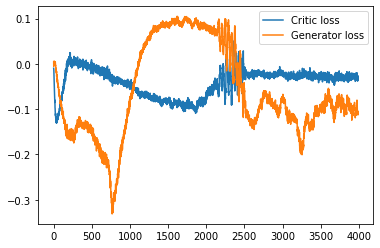

**** Iter 4000   Val ROC 0.948, AP: 0.941, EO 0.199 ****
5000   /200000   training iterations, took 1692 seconds so far...


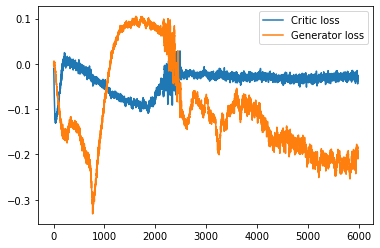

**** Iter 6000   Val ROC 0.951, AP: 0.949, EO 0.245 ****
7500   /200000   training iterations, took 2532 seconds so far...


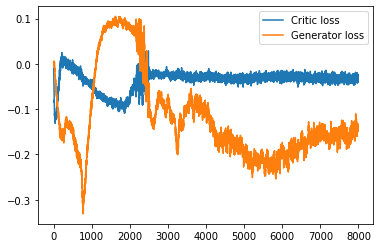

**** Iter 8000   Val ROC 0.953, AP: 0.950, EO 0.256 ****


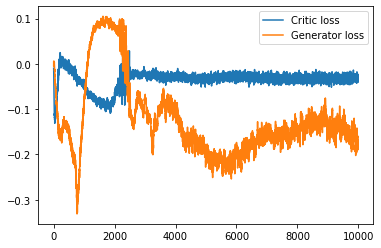

10000  /200000   training iterations, took 3372 seconds so far...
**** Iter 10000  Val ROC 0.952, AP: 0.947, EO 0.272 ****


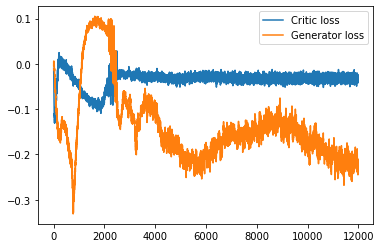

**** Iter 12000  Val ROC 0.948, AP: 0.942, EO 0.301 ****
12500  /200000   training iterations, took 4231 seconds so far...


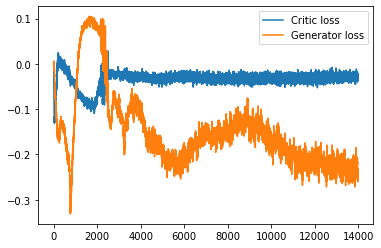

**** Iter 14000  Val ROC 0.948, AP: 0.943, EO 0.311 ****
15000  /200000   training iterations, took 5072 seconds so far...


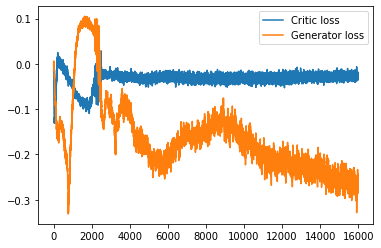

**** Iter 16000  Val ROC 0.947, AP: 0.943, EO 0.343 ****
17500  /200000   training iterations, took 5916 seconds so far...


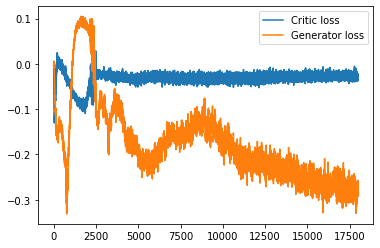

**** Iter 18000  Val ROC 0.945, AP: 0.936, EO 0.358 ****


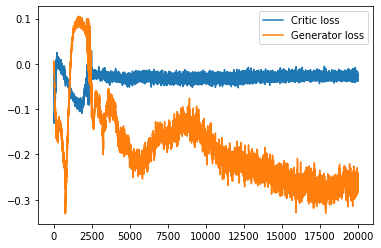

20000  /200000   training iterations, took 6757 seconds so far...
**** Iter 20000  Val ROC 0.946, AP: 0.938, EO 0.373 ****


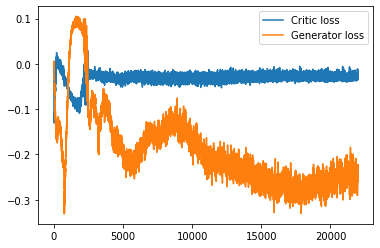

**** Iter 22000  Val ROC 0.945, AP: 0.940, EO 0.389 ****
22500  /200000   training iterations, took 7612 seconds so far...


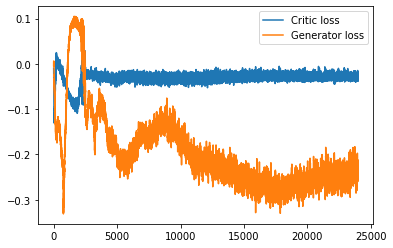

**** Iter 24000  Val ROC 0.941, AP: 0.935, EO 0.405 ****
25000  /200000   training iterations, took 8454 seconds so far...


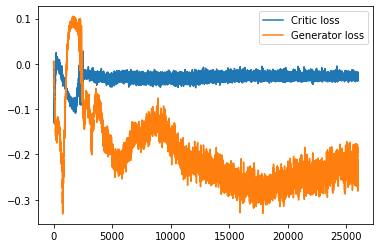

**** Iter 26000  Val ROC 0.938, AP: 0.932, EO 0.424 ****
27500  /200000   training iterations, took 9296 seconds so far...


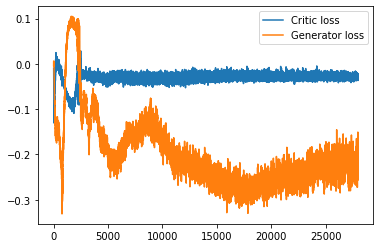

**** Iter 28000  Val ROC 0.939, AP: 0.931, EO 0.441 ****


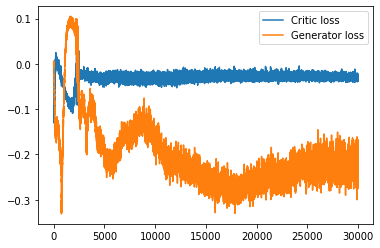

30000  /200000   training iterations, took 10138 seconds so far...
**** Iter 30000  Val ROC 0.935, AP: 0.925, EO 0.456 ****


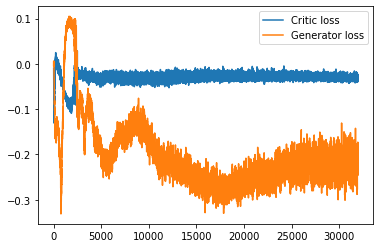

**** Iter 32000  Val ROC 0.935, AP: 0.928, EO 0.462 ****
32500  /200000   training iterations, took 10997 seconds so far...


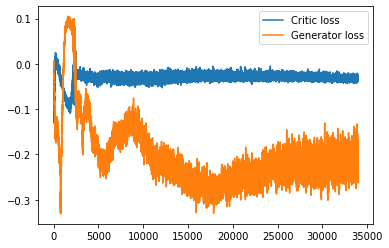

**** Iter 34000  Val ROC 0.936, AP: 0.930, EO 0.474 ****
35000  /200000   training iterations, took 11839 seconds so far...


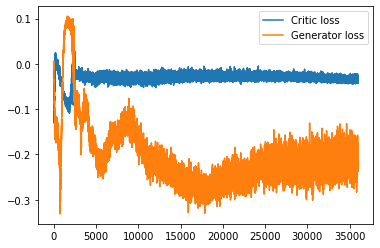

**** Iter 36000  Val ROC 0.933, AP: 0.927, EO 0.474 ****
37500  /200000   training iterations, took 12683 seconds so far...


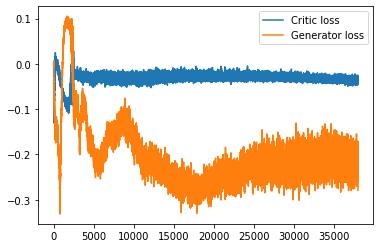

**** Iter 38000  Val ROC 0.936, AP: 0.931, EO 0.487 ****


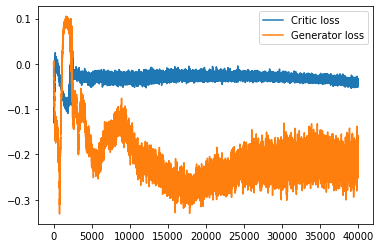

40000  /200000   training iterations, took 13532 seconds so far...
**** Iter 40000  Val ROC 0.939, AP: 0.935, EO 0.486 ****


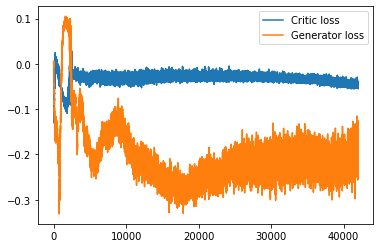

**** Iter 42000  Val ROC 0.937, AP: 0.933, EO 0.484 ****
42500  /200000   training iterations, took 14394 seconds so far...


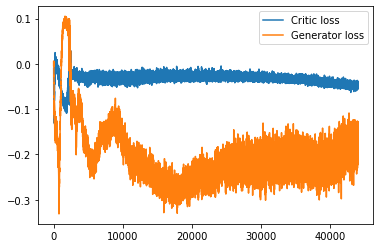

**** Iter 44000  Val ROC 0.939, AP: 0.934, EO 0.486 ****
45000  /200000   training iterations, took 15235 seconds so far...


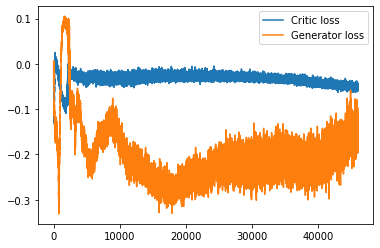

**** Iter 46000  Val ROC 0.941, AP: 0.935, EO 0.491 ****
47500  /200000   training iterations, took 16079 seconds so far...


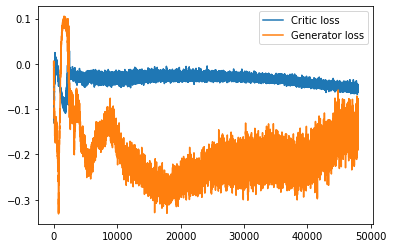

**** Iter 48000  Val ROC 0.941, AP: 0.937, EO 0.490 ****


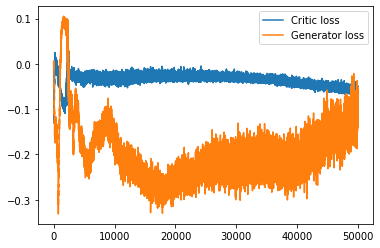

50000  /200000   training iterations, took 16921 seconds so far...
**** Iter 50000  Val ROC 0.939, AP: 0.935, EO 0.490 ****


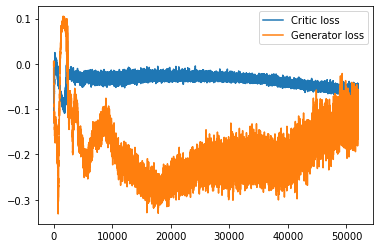

**** Iter 52000  Val ROC 0.940, AP: 0.935, EO 0.495 ****
52500  /200000   training iterations, took 17781 seconds so far...


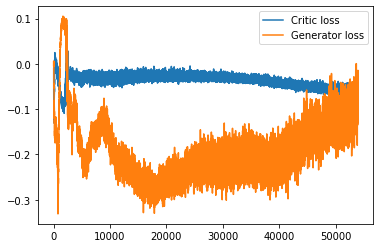

**** Iter 54000  Val ROC 0.940, AP: 0.934, EO 0.492 ****
55000  /200000   training iterations, took 18624 seconds so far...


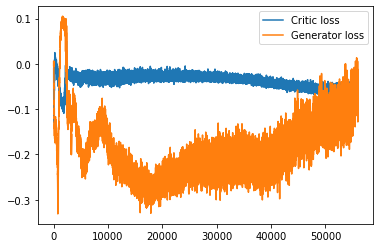

**** Iter 56000  Val ROC 0.939, AP: 0.936, EO 0.487 ****
57500  /200000   training iterations, took 19467 seconds so far...


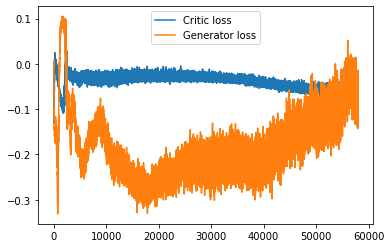

**** Iter 58000  Val ROC 0.939, AP: 0.936, EO 0.488 ****


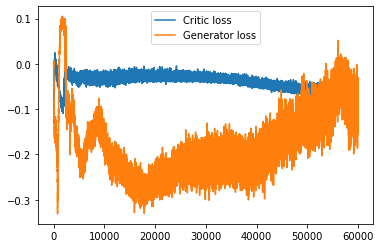

60000  /200000   training iterations, took 20312 seconds so far...
**** Iter 60000  Val ROC 0.942, AP: 0.938, EO 0.493 ****


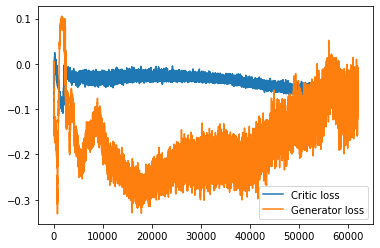

**** Iter 62000  Val ROC 0.939, AP: 0.934, EO 0.490 ****
62500  /200000   training iterations, took 21171 seconds so far...


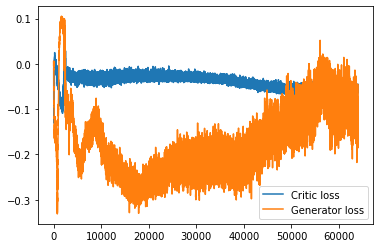

**** Iter 64000  Val ROC 0.939, AP: 0.936, EO 0.495 ****
65000  /200000   training iterations, took 22015 seconds so far...


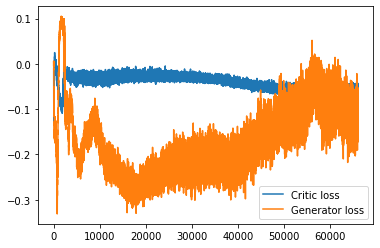

**** Iter 66000  Val ROC 0.940, AP: 0.935, EO 0.491 ****
67500  /200000   training iterations, took 22860 seconds so far...


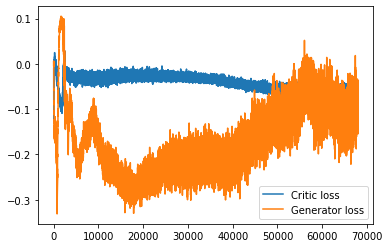

**** Iter 68000  Val ROC 0.942, AP: 0.936, EO 0.496 ****


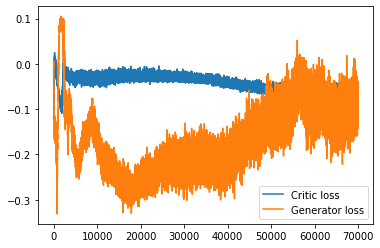

70000  /200000   training iterations, took 23705 seconds so far...
**** Iter 70000  Val ROC 0.940, AP: 0.935, EO 0.494 ****


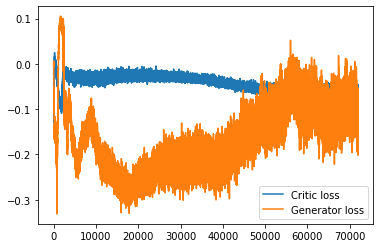

**** Iter 72000  Val ROC 0.940, AP: 0.936, EO 0.491 ****
72500  /200000   training iterations, took 24568 seconds so far...


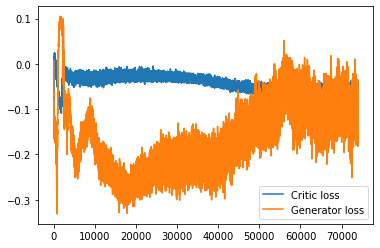

**** Iter 74000  Val ROC 0.942, AP: 0.937, EO 0.497 ****
75000  /200000   training iterations, took 25410 seconds so far...


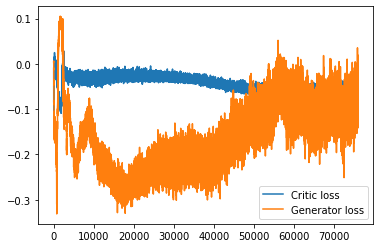

**** Iter 76000  Val ROC 0.940, AP: 0.937, EO 0.492 ****
77500  /200000   training iterations, took 26253 seconds so far...


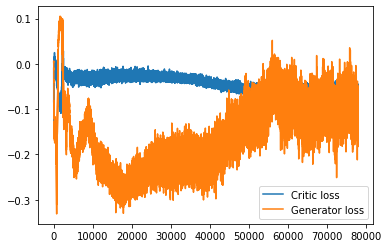

**** Iter 78000  Val ROC 0.939, AP: 0.937, EO 0.493 ****


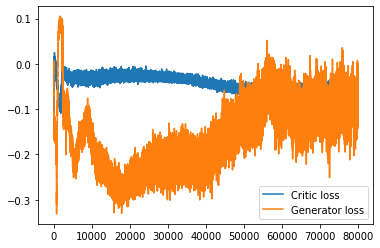

80000  /200000   training iterations, took 27093 seconds so far...
**** Iter 80000  Val ROC 0.943, AP: 0.939, EO 0.492 ****


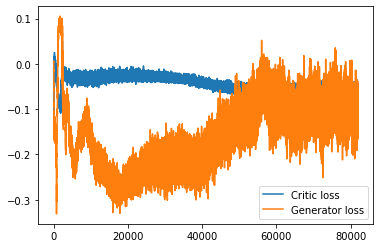

**** Iter 82000  Val ROC 0.941, AP: 0.938, EO 0.494 ****
82500  /200000   training iterations, took 27956 seconds so far...


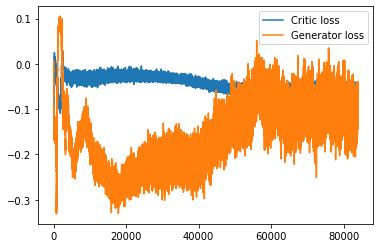

**** Iter 84000  Val ROC 0.939, AP: 0.935, EO 0.500 ****
85000  /200000   training iterations, took 28797 seconds so far...


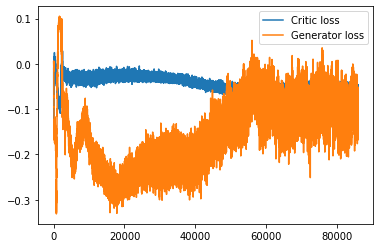

**** Iter 86000  Val ROC 0.940, AP: 0.937, EO 0.495 ****
87500  /200000   training iterations, took 29637 seconds so far...


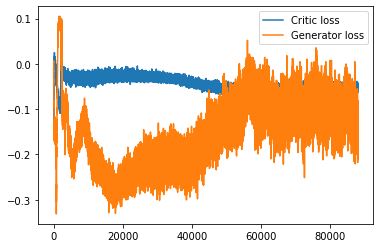

**** Iter 88000  Val ROC 0.940, AP: 0.936, EO 0.496 ****


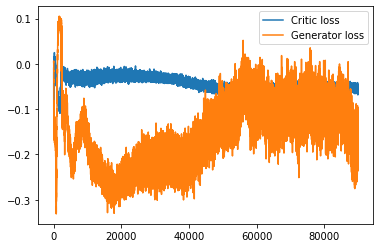

90000  /200000   training iterations, took 30474 seconds so far...
**** Iter 90000  Val ROC 0.941, AP: 0.938, EO 0.505 ****


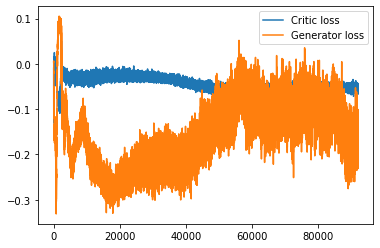

**** Iter 92000  Val ROC 0.939, AP: 0.936, EO 0.499 ****
92500  /200000   training iterations, took 31331 seconds so far...


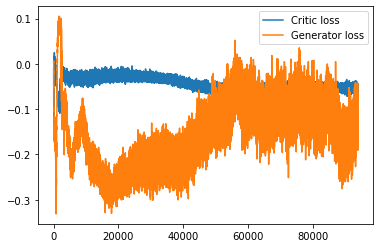

**** Iter 94000  Val ROC 0.941, AP: 0.937, EO 0.506 ****
95000  /200000   training iterations, took 32171 seconds so far...


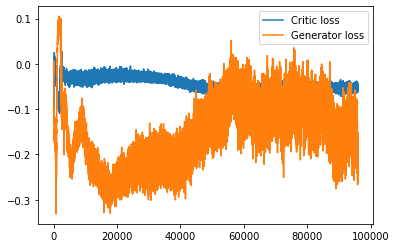

**** Iter 96000  Val ROC 0.942, AP: 0.938, EO 0.497 ****
97500  /200000   training iterations, took 33010 seconds so far...


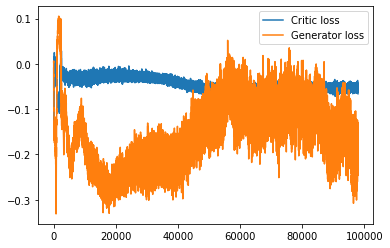

**** Iter 98000  Val ROC 0.938, AP: 0.935, EO 0.503 ****


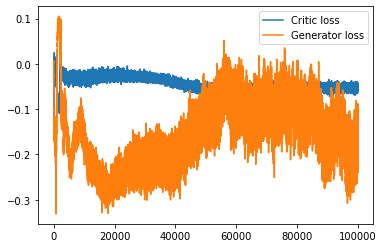

100000 /200000   training iterations, took 33852 seconds so far...
**** Iter 100000 Val ROC 0.940, AP: 0.937, EO 0.507 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


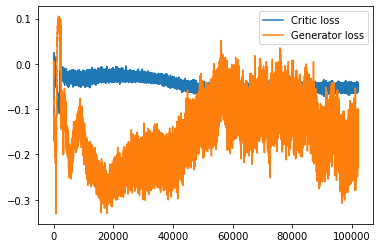

**** Iter 102000 Val ROC 0.941, AP: 0.938, EO 0.498 ****
102500 /200000   training iterations, took 34709 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


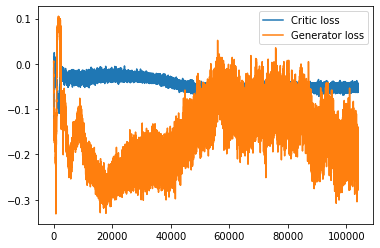

**** Iter 104000 Val ROC 0.941, AP: 0.938, EO 0.506 ****
105000 /200000   training iterations, took 35549 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


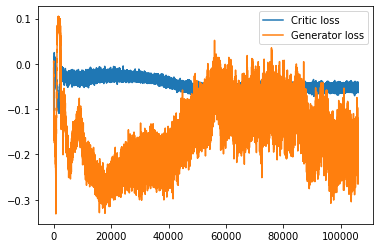

**** Iter 106000 Val ROC 0.943, AP: 0.938, EO 0.505 ****
107500 /200000   training iterations, took 36386 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


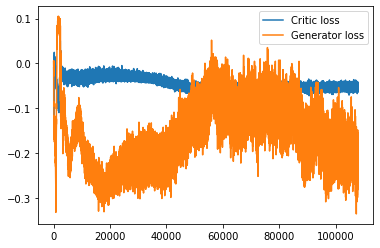

**** Iter 108000 Val ROC 0.941, AP: 0.937, EO 0.506 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


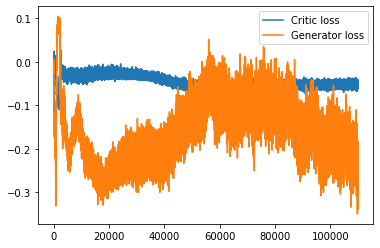

110000 /200000   training iterations, took 37229 seconds so far...
**** Iter 110000 Val ROC 0.941, AP: 0.938, EO 0.503 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


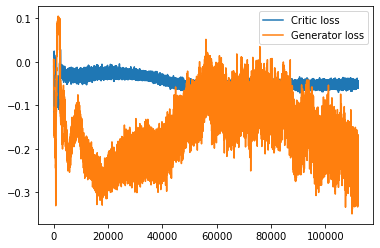

**** Iter 112000 Val ROC 0.941, AP: 0.938, EO 0.509 ****
112500 /200000   training iterations, took 38087 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


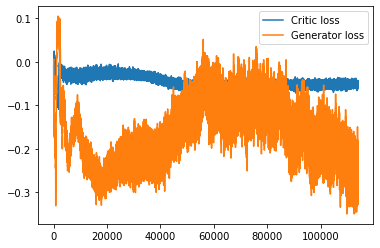

**** Iter 114000 Val ROC 0.939, AP: 0.936, EO 0.502 ****
115000 /200000   training iterations, took 38926 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


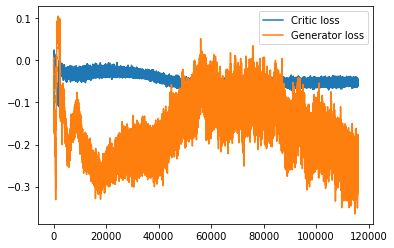

**** Iter 116000 Val ROC 0.939, AP: 0.936, EO 0.505 ****
117500 /200000   training iterations, took 39777 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


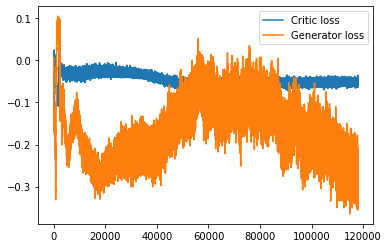

**** Iter 118000 Val ROC 0.938, AP: 0.936, EO 0.506 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


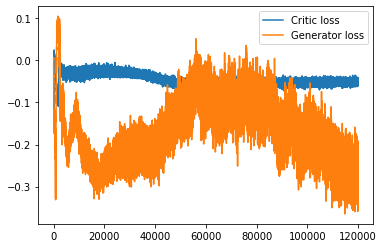

120000 /200000   training iterations, took 40616 seconds so far...
**** Iter 120000 Val ROC 0.940, AP: 0.938, EO 0.506 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


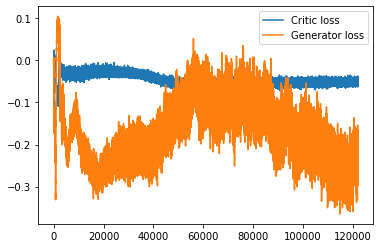

**** Iter 122000 Val ROC 0.941, AP: 0.938, EO 0.509 ****
122500 /200000   training iterations, took 41505 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


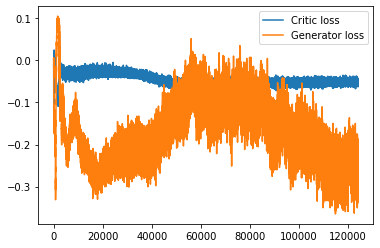

**** Iter 124000 Val ROC 0.940, AP: 0.937, EO 0.509 ****
125000 /200000   training iterations, took 42361 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


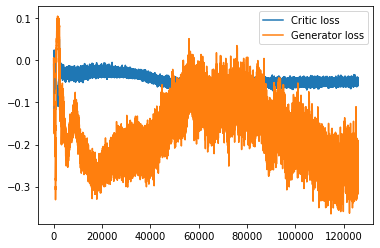

**** Iter 126000 Val ROC 0.942, AP: 0.939, EO 0.511 ****
127500 /200000   training iterations, took 43274 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


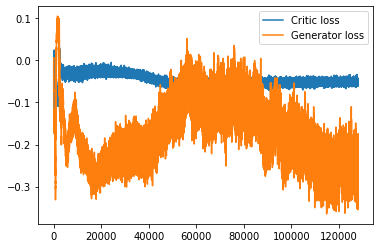

**** Iter 128000 Val ROC 0.940, AP: 0.937, EO 0.510 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


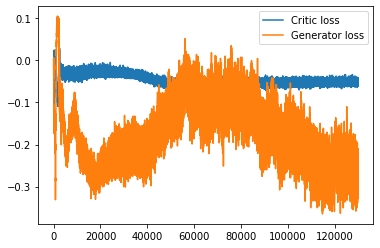

130000 /200000   training iterations, took 44118 seconds so far...
**** Iter 130000 Val ROC 0.941, AP: 0.938, EO 0.506 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


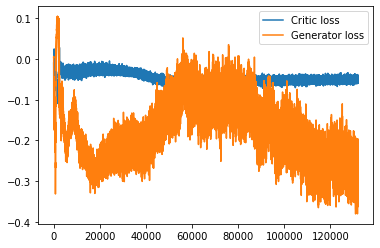

**** Iter 132000 Val ROC 0.939, AP: 0.937, EO 0.515 ****
132500 /200000   training iterations, took 44982 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


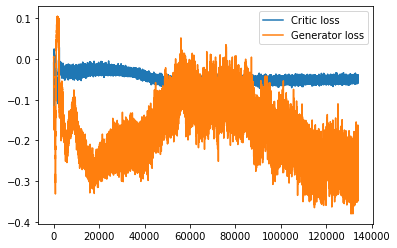

**** Iter 134000 Val ROC 0.940, AP: 0.937, EO 0.513 ****
135000 /200000   training iterations, took 45827 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


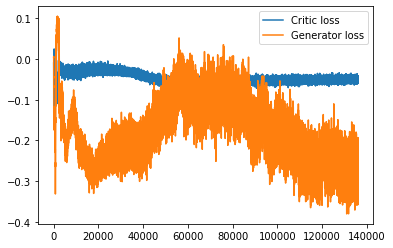

**** Iter 136000 Val ROC 0.941, AP: 0.938, EO 0.515 ****
137500 /200000   training iterations, took 46714 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


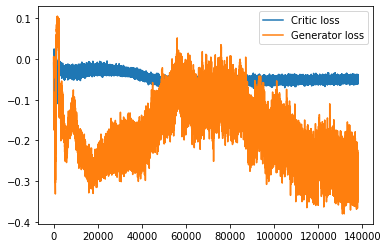

**** Iter 138000 Val ROC 0.940, AP: 0.937, EO 0.512 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


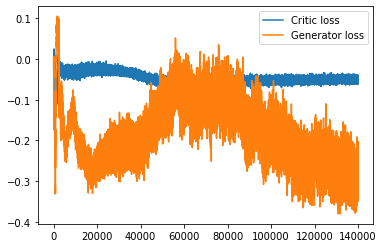

140000 /200000   training iterations, took 47567 seconds so far...
**** Iter 140000 Val ROC 0.940, AP: 0.937, EO 0.507 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


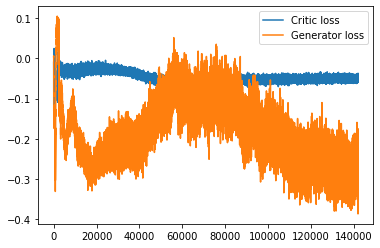

**** Iter 142000 Val ROC 0.939, AP: 0.937, EO 0.518 ****
142500 /200000   training iterations, took 48426 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


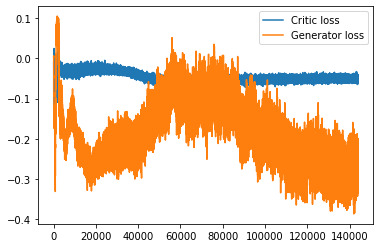

**** Iter 144000 Val ROC 0.940, AP: 0.937, EO 0.513 ****
145000 /200000   training iterations, took 49267 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


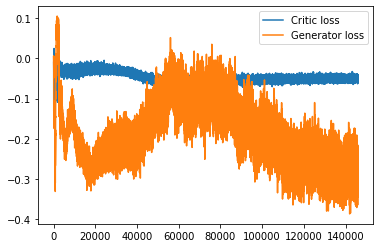

**** Iter 146000 Val ROC 0.939, AP: 0.936, EO 0.521 ****
**** EARLY STOPPING AFTER 146000 ITERATIONS ****
**** Training completed after 146000 iterations. ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


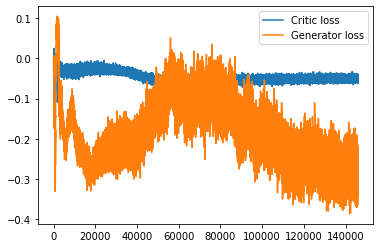

**** Using EO criterion of 0.52 for early stopping
**** Saving snapshots into ../snapshots/model_best_62.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****


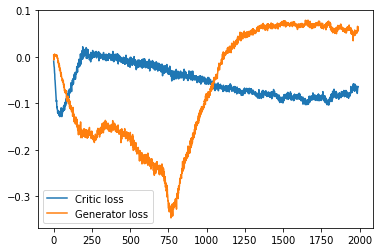

**** Iter 2000   Val ROC 0.917, AP: 0.906, EO 0.127 ****
2500   /200000   training iterations, took 856 seconds so far...


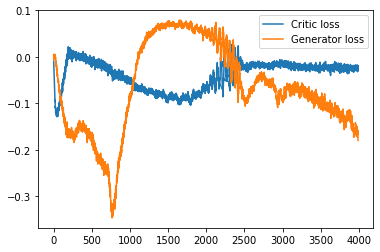

**** Iter 4000   Val ROC 0.947, AP: 0.940, EO 0.202 ****
5000   /200000   training iterations, took 1699 seconds so far...


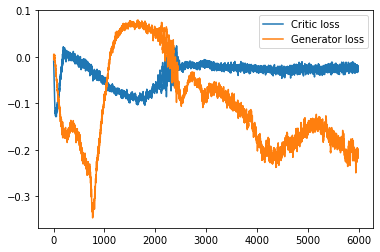

**** Iter 6000   Val ROC 0.949, AP: 0.948, EO 0.240 ****
7500   /200000   training iterations, took 2540 seconds so far...


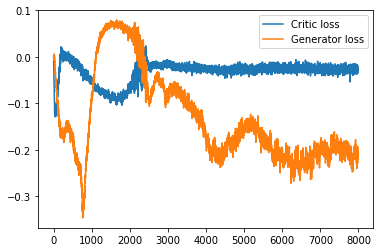

**** Iter 8000   Val ROC 0.951, AP: 0.946, EO 0.261 ****


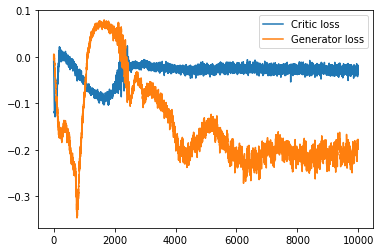

10000  /200000   training iterations, took 3380 seconds so far...
**** Iter 10000  Val ROC 0.946, AP: 0.942, EO 0.283 ****


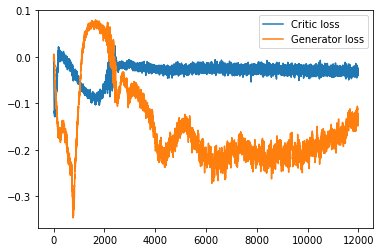

**** Iter 12000  Val ROC 0.945, AP: 0.939, EO 0.304 ****
12500  /200000   training iterations, took 4238 seconds so far...


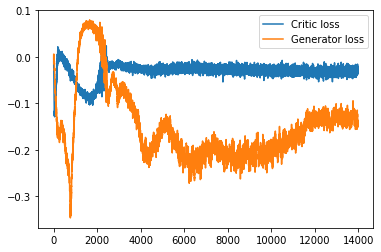

**** Iter 14000  Val ROC 0.944, AP: 0.938, EO 0.318 ****
15000  /200000   training iterations, took 5079 seconds so far...


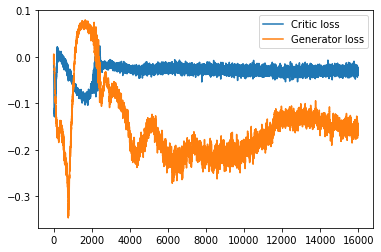

**** Iter 16000  Val ROC 0.940, AP: 0.936, EO 0.350 ****
17500  /200000   training iterations, took 5921 seconds so far...


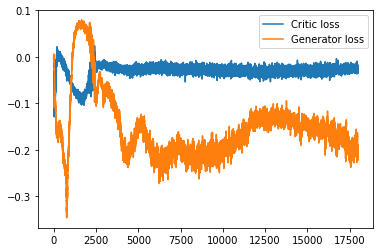

**** Iter 18000  Val ROC 0.943, AP: 0.939, EO 0.356 ****


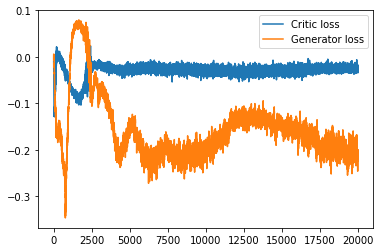

20000  /200000   training iterations, took 6763 seconds so far...
**** Iter 20000  Val ROC 0.940, AP: 0.933, EO 0.375 ****


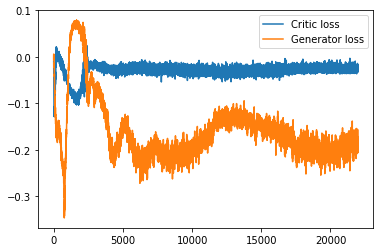

**** Iter 22000  Val ROC 0.935, AP: 0.928, EO 0.390 ****
22500  /200000   training iterations, took 7623 seconds so far...


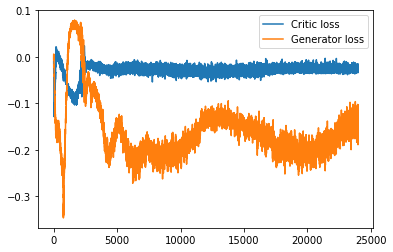

**** Iter 24000  Val ROC 0.936, AP: 0.929, EO 0.405 ****
25000  /200000   training iterations, took 8463 seconds so far...


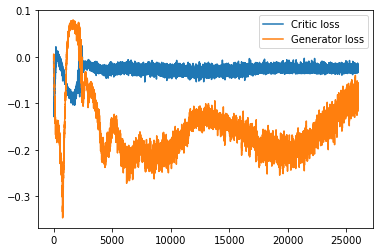

**** Iter 26000  Val ROC 0.932, AP: 0.921, EO 0.421 ****
27500  /200000   training iterations, took 9304 seconds so far...


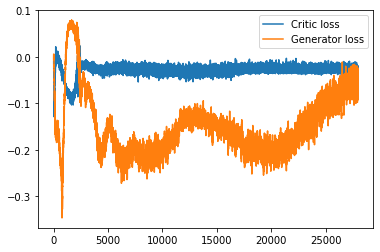

**** Iter 28000  Val ROC 0.937, AP: 0.931, EO 0.433 ****


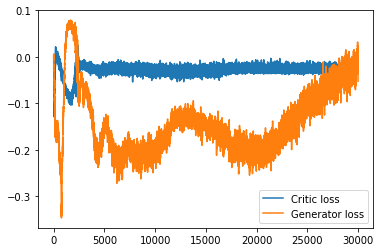

30000  /200000   training iterations, took 10148 seconds so far...
**** Iter 30000  Val ROC 0.929, AP: 0.925, EO 0.445 ****


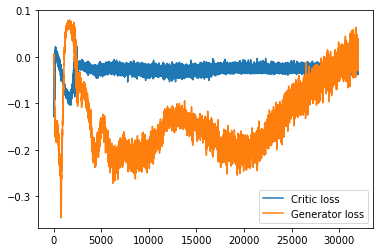

**** Iter 32000  Val ROC 0.930, AP: 0.922, EO 0.466 ****
32500  /200000   training iterations, took 11005 seconds so far...


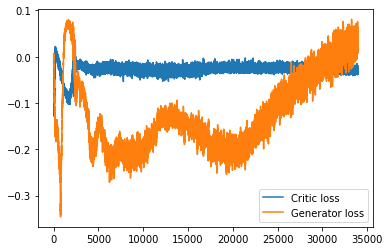

**** Iter 34000  Val ROC 0.932, AP: 0.923, EO 0.469 ****
35000  /200000   training iterations, took 11853 seconds so far...


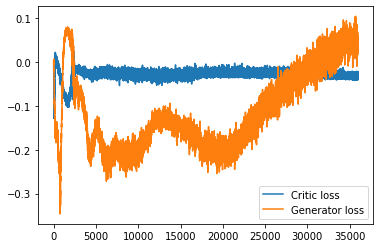

**** Iter 36000  Val ROC 0.932, AP: 0.925, EO 0.473 ****
37500  /200000   training iterations, took 12696 seconds so far...


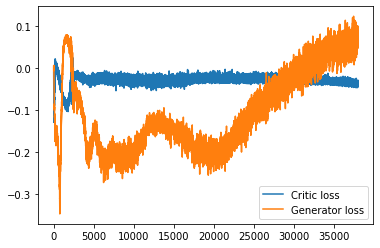

**** Iter 38000  Val ROC 0.933, AP: 0.928, EO 0.482 ****


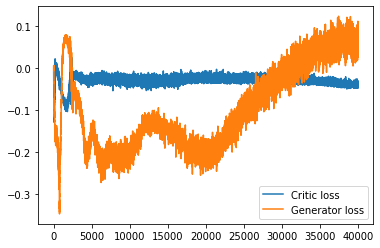

40000  /200000   training iterations, took 13541 seconds so far...
**** Iter 40000  Val ROC 0.932, AP: 0.929, EO 0.482 ****


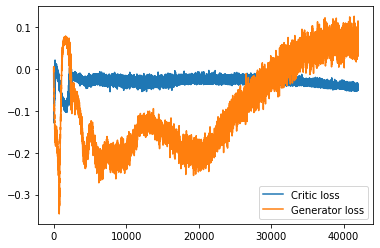

**** Iter 42000  Val ROC 0.936, AP: 0.932, EO 0.482 ****
42500  /200000   training iterations, took 14409 seconds so far...


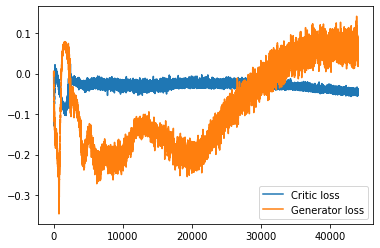

**** Iter 44000  Val ROC 0.936, AP: 0.932, EO 0.489 ****
45000  /200000   training iterations, took 15253 seconds so far...


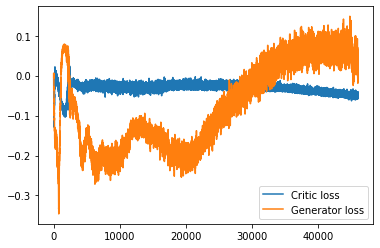

**** Iter 46000  Val ROC 0.934, AP: 0.930, EO 0.490 ****
47500  /200000   training iterations, took 16099 seconds so far...


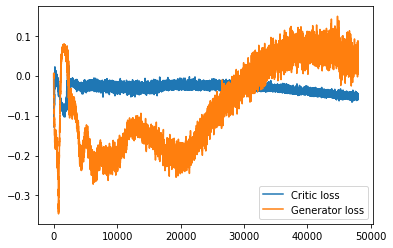

**** Iter 48000  Val ROC 0.935, AP: 0.930, EO 0.485 ****


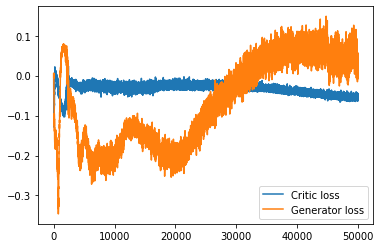

50000  /200000   training iterations, took 16948 seconds so far...
**** Iter 50000  Val ROC 0.935, AP: 0.929, EO 0.489 ****


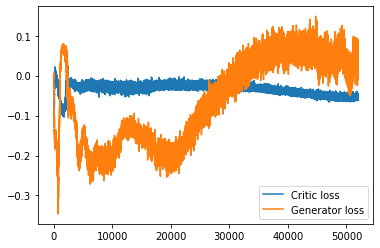

**** Iter 52000  Val ROC 0.933, AP: 0.927, EO 0.481 ****
52500  /200000   training iterations, took 17811 seconds so far...


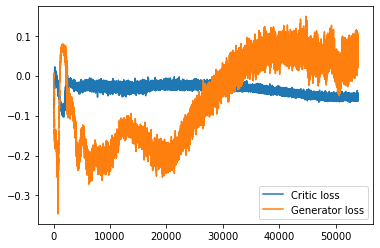

**** Iter 54000  Val ROC 0.935, AP: 0.931, EO 0.492 ****
55000  /200000   training iterations, took 18660 seconds so far...


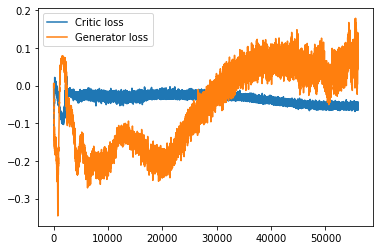

**** Iter 56000  Val ROC 0.935, AP: 0.930, EO 0.490 ****
57500  /200000   training iterations, took 19504 seconds so far...


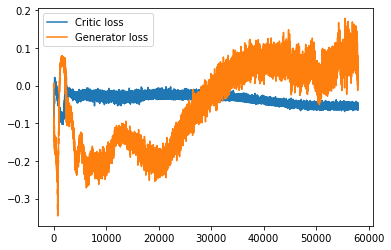

**** Iter 58000  Val ROC 0.934, AP: 0.930, EO 0.495 ****


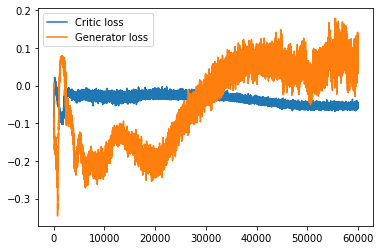

60000  /200000   training iterations, took 20349 seconds so far...
**** Iter 60000  Val ROC 0.936, AP: 0.934, EO 0.489 ****


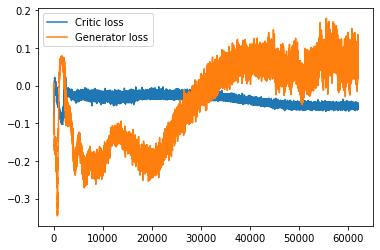

**** Iter 62000  Val ROC 0.936, AP: 0.933, EO 0.493 ****
62500  /200000   training iterations, took 21214 seconds so far...


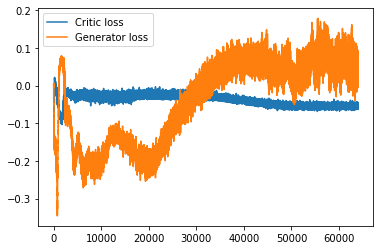

**** Iter 64000  Val ROC 0.934, AP: 0.931, EO 0.497 ****
65000  /200000   training iterations, took 22063 seconds so far...


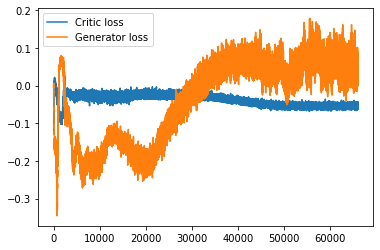

**** Iter 66000  Val ROC 0.934, AP: 0.930, EO 0.488 ****
67500  /200000   training iterations, took 22909 seconds so far...


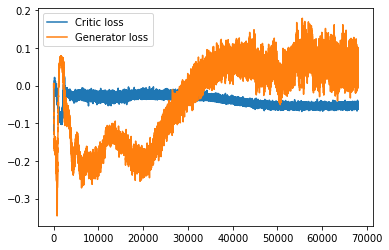

**** Iter 68000  Val ROC 0.937, AP: 0.934, EO 0.491 ****


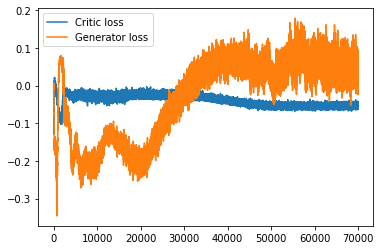

70000  /200000   training iterations, took 23753 seconds so far...
**** Iter 70000  Val ROC 0.937, AP: 0.934, EO 0.495 ****


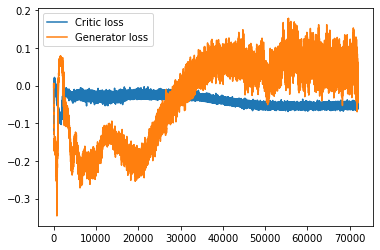

**** Iter 72000  Val ROC 0.937, AP: 0.932, EO 0.490 ****
72500  /200000   training iterations, took 24617 seconds so far...


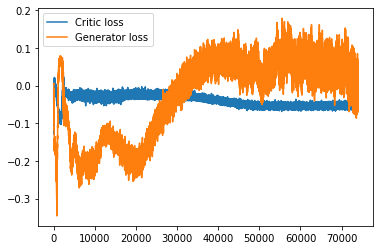

**** Iter 74000  Val ROC 0.937, AP: 0.933, EO 0.495 ****
75000  /200000   training iterations, took 25460 seconds so far...


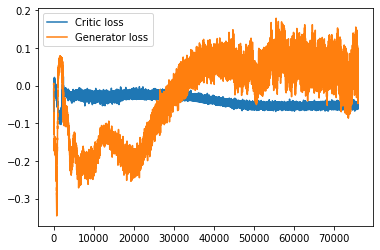

**** Iter 76000  Val ROC 0.935, AP: 0.931, EO 0.490 ****
77500  /200000   training iterations, took 26303 seconds so far...


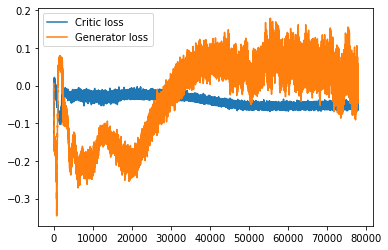

**** Iter 78000  Val ROC 0.936, AP: 0.929, EO 0.491 ****


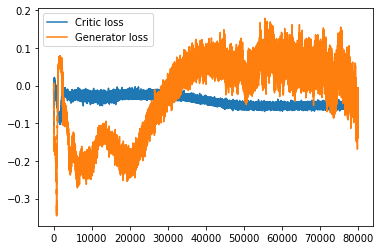

80000  /200000   training iterations, took 27154 seconds so far...
**** Iter 80000  Val ROC 0.936, AP: 0.931, EO 0.490 ****


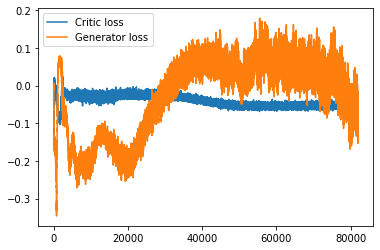

**** Iter 82000  Val ROC 0.937, AP: 0.933, EO 0.495 ****
82500  /200000   training iterations, took 28015 seconds so far...


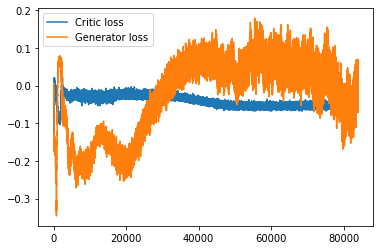

**** Iter 84000  Val ROC 0.938, AP: 0.933, EO 0.496 ****
85000  /200000   training iterations, took 28859 seconds so far...


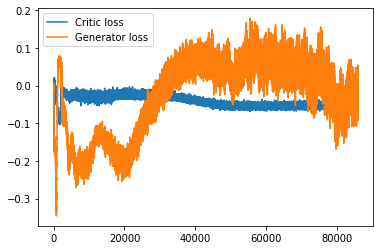

**** Iter 86000  Val ROC 0.939, AP: 0.933, EO 0.497 ****
87500  /200000   training iterations, took 29704 seconds so far...


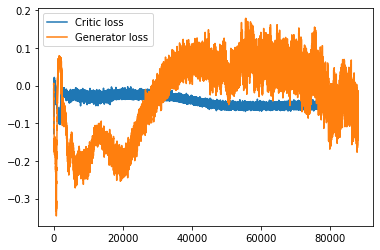

**** Iter 88000  Val ROC 0.939, AP: 0.935, EO 0.491 ****


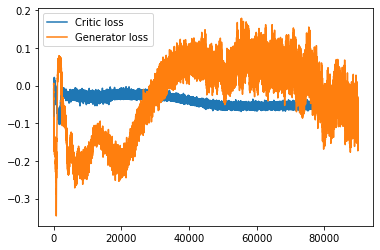

90000  /200000   training iterations, took 30552 seconds so far...
**** Iter 90000  Val ROC 0.938, AP: 0.932, EO 0.491 ****


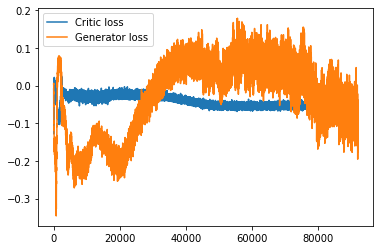

**** Iter 92000  Val ROC 0.937, AP: 0.934, EO 0.496 ****
92500  /200000   training iterations, took 31417 seconds so far...


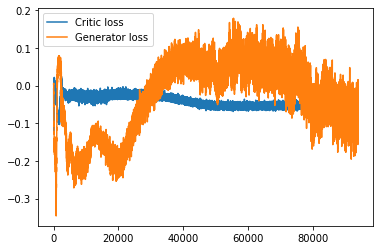

**** Iter 94000  Val ROC 0.938, AP: 0.935, EO 0.496 ****
95000  /200000   training iterations, took 32260 seconds so far...


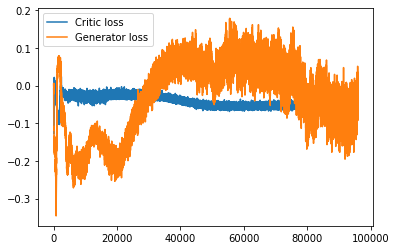

**** Iter 96000  Val ROC 0.937, AP: 0.934, EO 0.498 ****
97500  /200000   training iterations, took 33107 seconds so far...


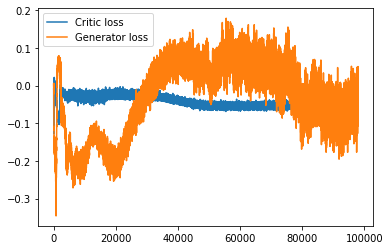

**** Iter 98000  Val ROC 0.936, AP: 0.932, EO 0.500 ****


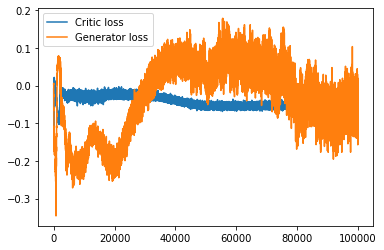

100000 /200000   training iterations, took 33953 seconds so far...
**** Iter 100000 Val ROC 0.938, AP: 0.934, EO 0.498 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


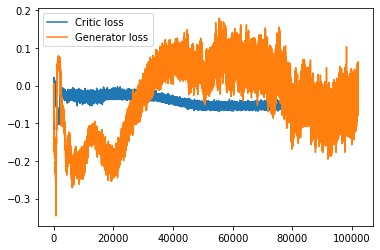

**** Iter 102000 Val ROC 0.937, AP: 0.933, EO 0.500 ****
102500 /200000   training iterations, took 34817 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


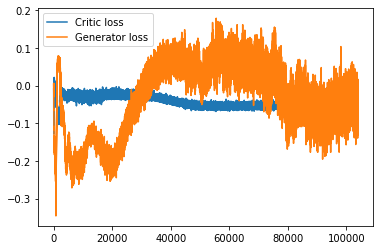

**** Iter 104000 Val ROC 0.938, AP: 0.935, EO 0.499 ****
105000 /200000   training iterations, took 35661 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


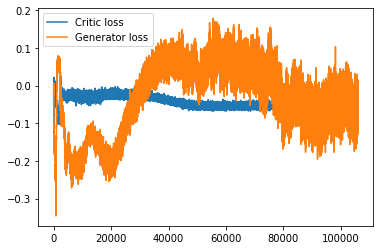

**** Iter 106000 Val ROC 0.937, AP: 0.934, EO 0.496 ****
107500 /200000   training iterations, took 36507 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


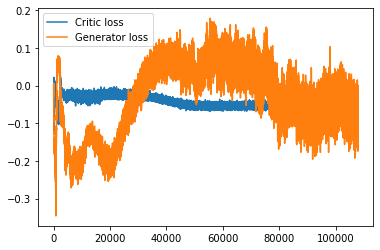

**** Iter 108000 Val ROC 0.938, AP: 0.934, EO 0.500 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


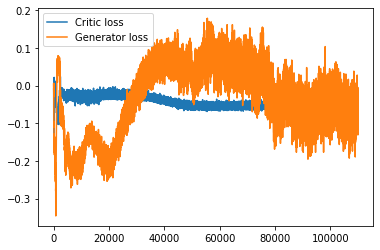

110000 /200000   training iterations, took 37355 seconds so far...
**** Iter 110000 Val ROC 0.940, AP: 0.934, EO 0.502 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


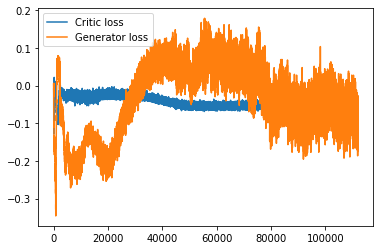

**** Iter 112000 Val ROC 0.939, AP: 0.935, EO 0.500 ****
112500 /200000   training iterations, took 38218 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


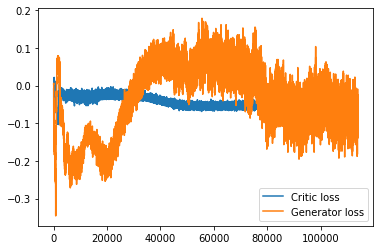

**** Iter 114000 Val ROC 0.937, AP: 0.933, EO 0.503 ****
115000 /200000   training iterations, took 39063 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


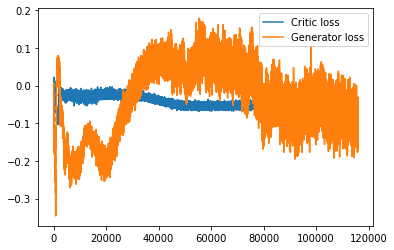

**** Iter 116000 Val ROC 0.938, AP: 0.935, EO 0.502 ****
117500 /200000   training iterations, took 39910 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


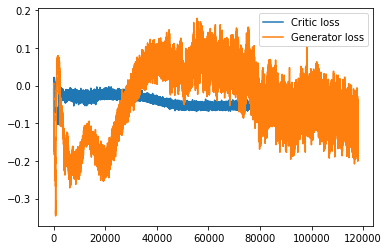

**** Iter 118000 Val ROC 0.937, AP: 0.935, EO 0.497 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


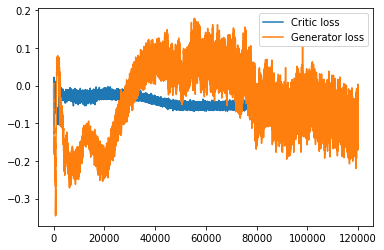

120000 /200000   training iterations, took 40759 seconds so far...
**** Iter 120000 Val ROC 0.938, AP: 0.934, EO 0.506 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


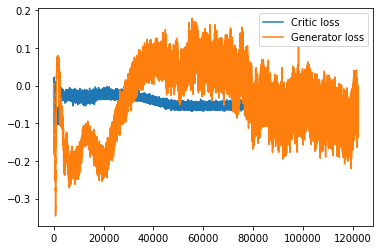

**** Iter 122000 Val ROC 0.936, AP: 0.933, EO 0.505 ****
122500 /200000   training iterations, took 41624 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


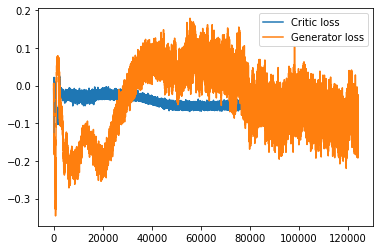

**** Iter 124000 Val ROC 0.940, AP: 0.937, EO 0.503 ****
125000 /200000   training iterations, took 42469 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


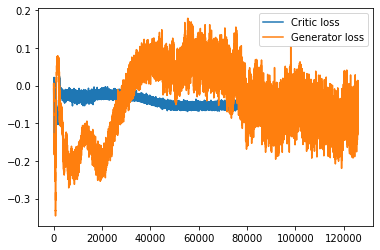

**** Iter 126000 Val ROC 0.937, AP: 0.935, EO 0.501 ****
127500 /200000   training iterations, took 43313 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


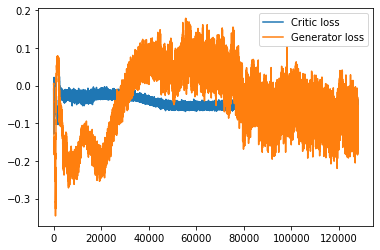

**** Iter 128000 Val ROC 0.939, AP: 0.936, EO 0.498 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


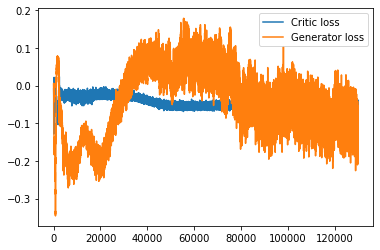

130000 /200000   training iterations, took 44157 seconds so far...
**** Iter 130000 Val ROC 0.936, AP: 0.933, EO 0.504 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


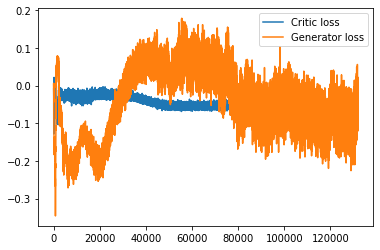

**** Iter 132000 Val ROC 0.937, AP: 0.934, EO 0.509 ****
132500 /200000   training iterations, took 45024 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


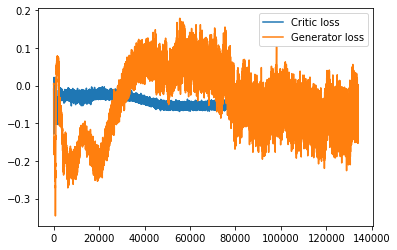

**** Iter 134000 Val ROC 0.937, AP: 0.933, EO 0.509 ****
135000 /200000   training iterations, took 45871 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


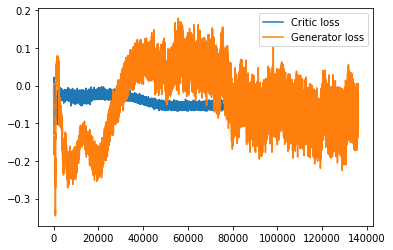

**** Iter 136000 Val ROC 0.936, AP: 0.933, EO 0.505 ****
137500 /200000   training iterations, took 46718 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


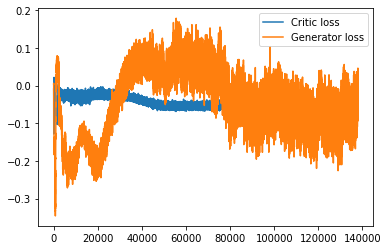

**** Iter 138000 Val ROC 0.936, AP: 0.932, EO 0.503 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


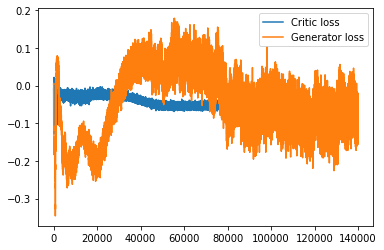

140000 /200000   training iterations, took 47565 seconds so far...
**** Iter 140000 Val ROC 0.935, AP: 0.933, EO 0.509 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


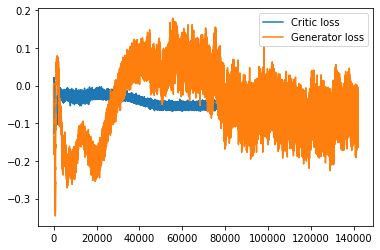

**** Iter 142000 Val ROC 0.937, AP: 0.935, EO 0.505 ****
142500 /200000   training iterations, took 48427 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


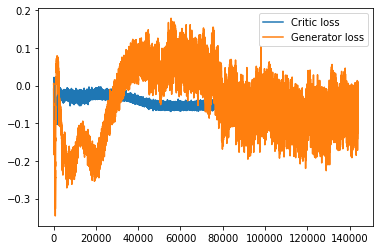

**** Iter 144000 Val ROC 0.938, AP: 0.935, EO 0.511 ****
145000 /200000   training iterations, took 49270 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


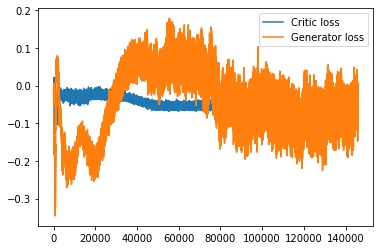

**** Iter 146000 Val ROC 0.937, AP: 0.934, EO 0.504 ****
147500 /200000   training iterations, took 50112 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


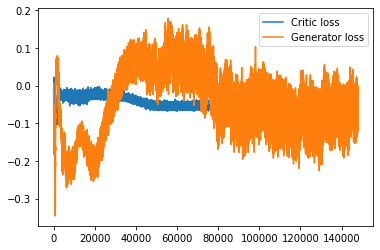

**** Iter 148000 Val ROC 0.936, AP: 0.933, EO 0.513 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


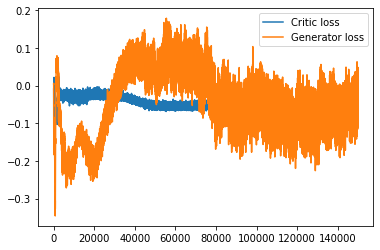

150000 /200000   training iterations, took 50955 seconds so far...
**** Iter 150000 Val ROC 0.937, AP: 0.935, EO 0.514 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


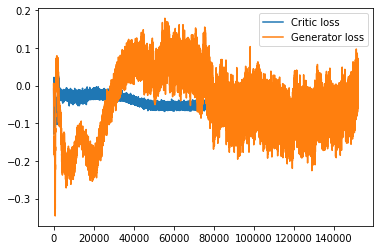

**** Iter 152000 Val ROC 0.937, AP: 0.934, EO 0.510 ****
152500 /200000   training iterations, took 51818 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


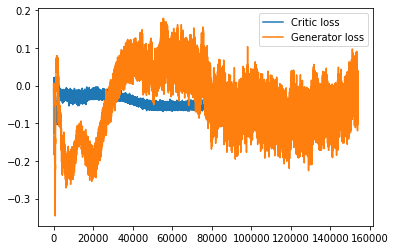

**** Iter 154000 Val ROC 0.934, AP: 0.932, EO 0.518 ****
155000 /200000   training iterations, took 52664 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


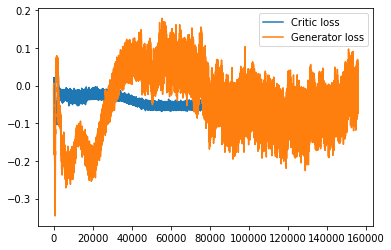

**** Iter 156000 Val ROC 0.936, AP: 0.933, EO 0.512 ****
157500 /200000   training iterations, took 53510 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


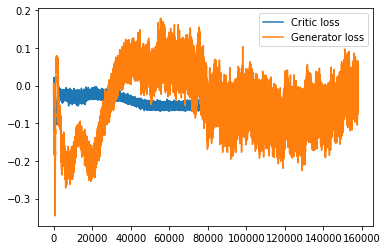

**** Iter 158000 Val ROC 0.936, AP: 0.933, EO 0.512 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


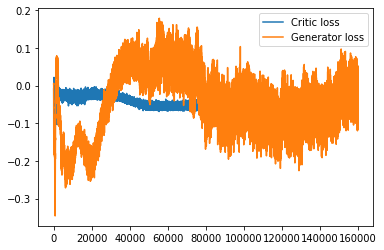

160000 /200000   training iterations, took 54356 seconds so far...
**** Iter 160000 Val ROC 0.936, AP: 0.934, EO 0.516 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


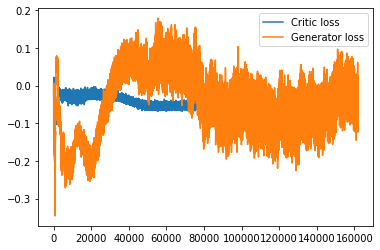

**** Iter 162000 Val ROC 0.935, AP: 0.931, EO 0.517 ****
162500 /200000   training iterations, took 55219 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


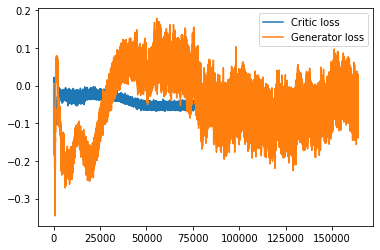

**** Iter 164000 Val ROC 0.935, AP: 0.931, EO 0.512 ****
165000 /200000   training iterations, took 56062 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


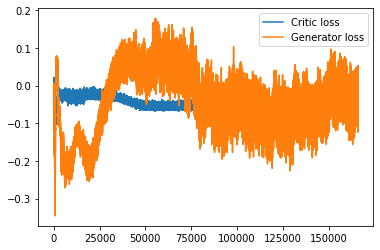

**** Iter 166000 Val ROC 0.936, AP: 0.929, EO 0.518 ****
167500 /200000   training iterations, took 56909 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


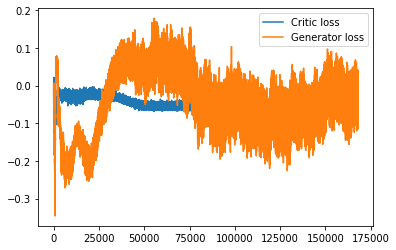

**** Iter 168000 Val ROC 0.934, AP: 0.929, EO 0.517 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


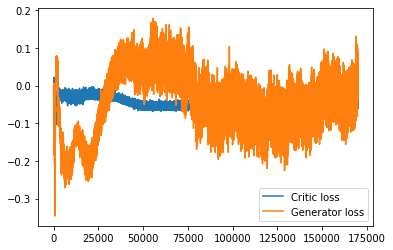

170000 /200000   training iterations, took 57757 seconds so far...
**** Iter 170000 Val ROC 0.934, AP: 0.930, EO 0.515 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


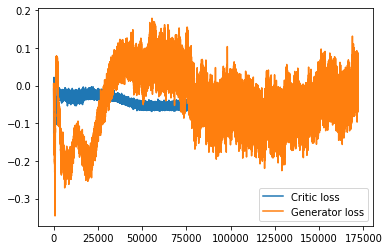

**** Iter 172000 Val ROC 0.933, AP: 0.931, EO 0.519 ****
172500 /200000   training iterations, took 58622 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


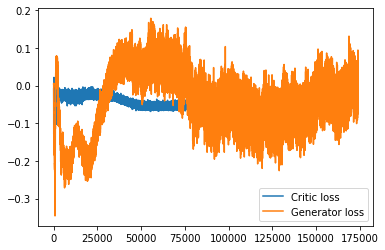

**** Iter 174000 Val ROC 0.935, AP: 0.931, EO 0.518 ****
175000 /200000   training iterations, took 59466 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


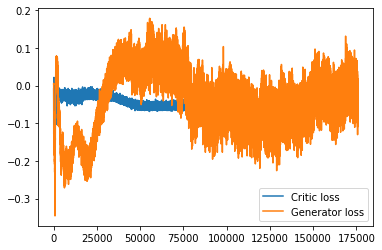

**** Iter 176000 Val ROC 0.935, AP: 0.931, EO 0.524 ****
**** EARLY STOPPING AFTER 176000 ITERATIONS ****
**** Training completed after 176000 iterations. ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


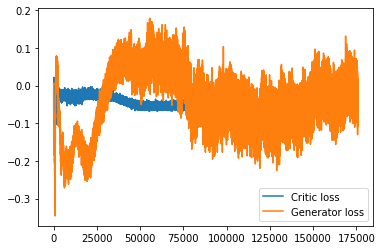

**** Using EO criterion of 0.52 for early stopping
**** Saving snapshots into ../snapshots/model_best_63.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****


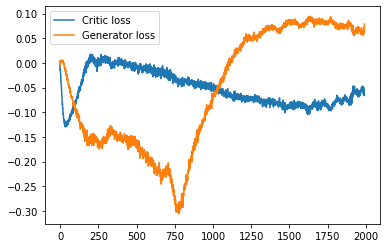

**** Iter 2000   Val ROC 0.917, AP: 0.908, EO 0.150 ****
2500   /200000   training iterations, took 852 seconds so far...


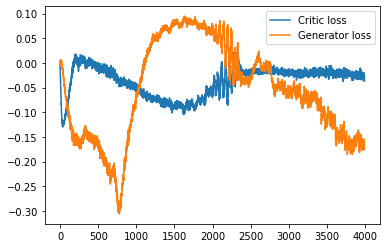

**** Iter 4000   Val ROC 0.946, AP: 0.939, EO 0.204 ****
5000   /200000   training iterations, took 1691 seconds so far...


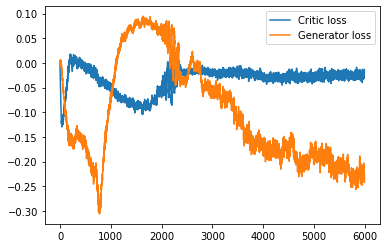

**** Iter 6000   Val ROC 0.952, AP: 0.949, EO 0.242 ****
7500   /200000   training iterations, took 2530 seconds so far...


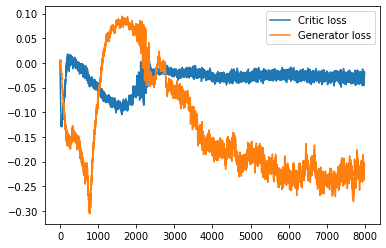

**** Iter 8000   Val ROC 0.952, AP: 0.948, EO 0.264 ****


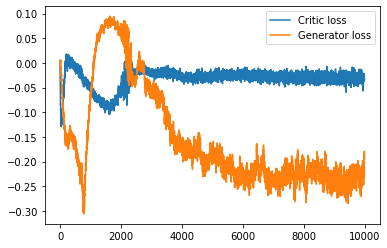

10000  /200000   training iterations, took 3369 seconds so far...
**** Iter 10000  Val ROC 0.950, AP: 0.947, EO 0.288 ****


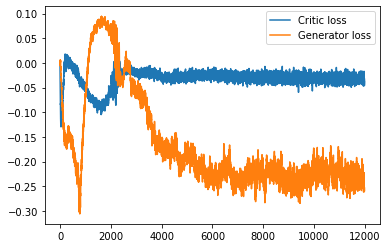

**** Iter 12000  Val ROC 0.946, AP: 0.942, EO 0.301 ****
12500  /200000   training iterations, took 4228 seconds so far...


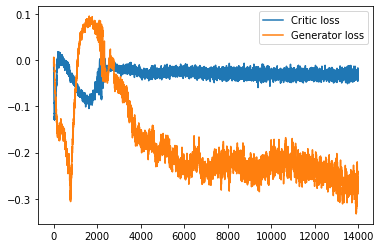

**** Iter 14000  Val ROC 0.947, AP: 0.940, EO 0.312 ****
15000  /200000   training iterations, took 5068 seconds so far...


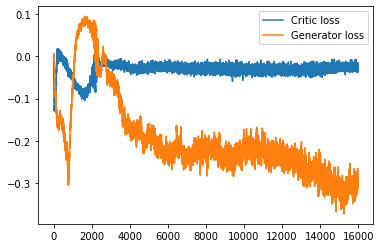

**** Iter 16000  Val ROC 0.945, AP: 0.941, EO 0.334 ****
17500  /200000   training iterations, took 5911 seconds so far...


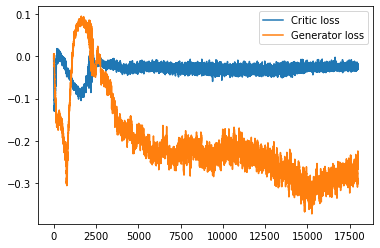

**** Iter 18000  Val ROC 0.939, AP: 0.935, EO 0.363 ****


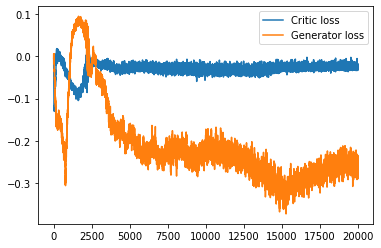

20000  /200000   training iterations, took 6752 seconds so far...
**** Iter 20000  Val ROC 0.942, AP: 0.937, EO 0.374 ****


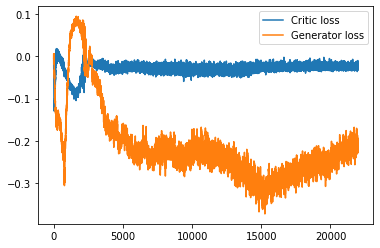

**** Iter 22000  Val ROC 0.939, AP: 0.935, EO 0.389 ****
22500  /200000   training iterations, took 7614 seconds so far...


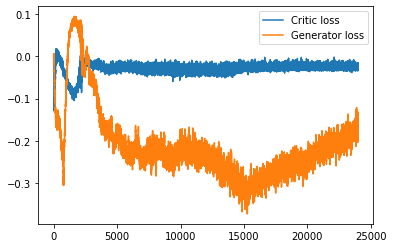

**** Iter 24000  Val ROC 0.939, AP: 0.931, EO 0.409 ****
25000  /200000   training iterations, took 8455 seconds so far...


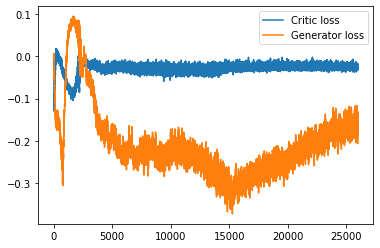

**** Iter 26000  Val ROC 0.940, AP: 0.935, EO 0.424 ****
27500  /200000   training iterations, took 9300 seconds so far...


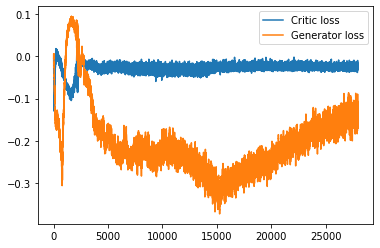

**** Iter 28000  Val ROC 0.941, AP: 0.936, EO 0.441 ****


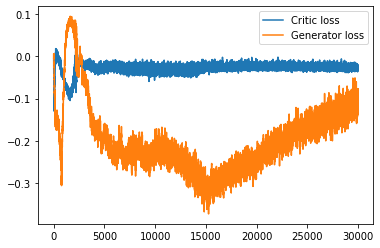

30000  /200000   training iterations, took 10138 seconds so far...
**** Iter 30000  Val ROC 0.935, AP: 0.929, EO 0.455 ****


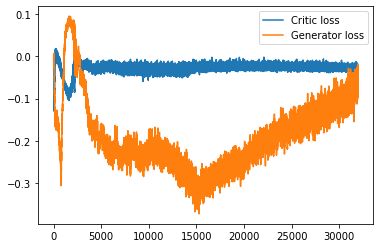

**** Iter 32000  Val ROC 0.940, AP: 0.934, EO 0.472 ****
32500  /200000   training iterations, took 11002 seconds so far...


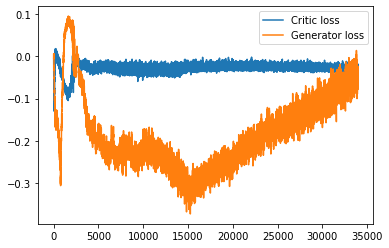

**** Iter 34000  Val ROC 0.936, AP: 0.930, EO 0.482 ****
35000  /200000   training iterations, took 11846 seconds so far...


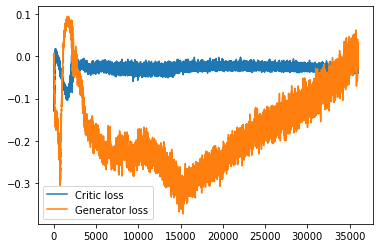

**** Iter 36000  Val ROC 0.937, AP: 0.929, EO 0.487 ****
37500  /200000   training iterations, took 12689 seconds so far...


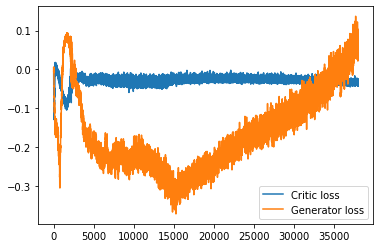

**** Iter 38000  Val ROC 0.937, AP: 0.929, EO 0.496 ****


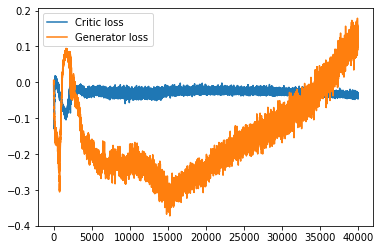

40000  /200000   training iterations, took 13530 seconds so far...
**** Iter 40000  Val ROC 0.938, AP: 0.931, EO 0.492 ****


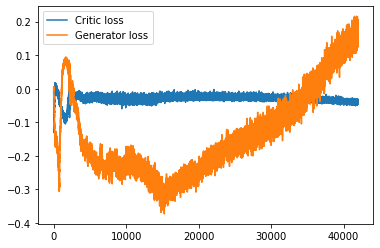

**** Iter 42000  Val ROC 0.943, AP: 0.936, EO 0.496 ****
42500  /200000   training iterations, took 14384 seconds so far...


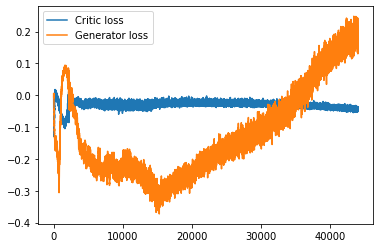

**** Iter 44000  Val ROC 0.941, AP: 0.936, EO 0.497 ****
45000  /200000   training iterations, took 15225 seconds so far...


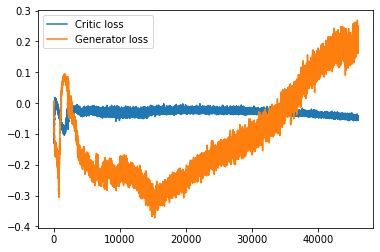

**** Iter 46000  Val ROC 0.940, AP: 0.935, EO 0.496 ****
47500  /200000   training iterations, took 16071 seconds so far...


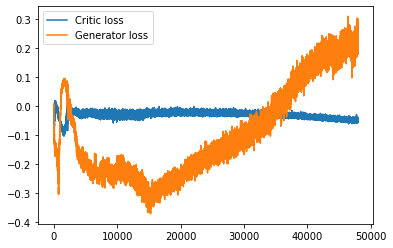

**** Iter 48000  Val ROC 0.941, AP: 0.937, EO 0.499 ****


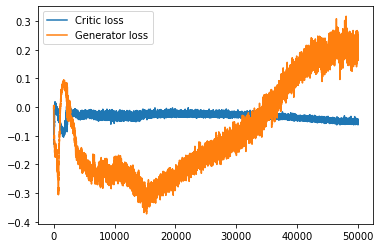

50000  /200000   training iterations, took 16917 seconds so far...
**** Iter 50000  Val ROC 0.941, AP: 0.936, EO 0.496 ****


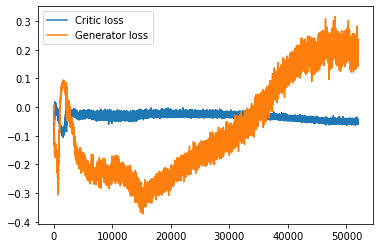

**** Iter 52000  Val ROC 0.941, AP: 0.936, EO 0.500 ****
52500  /200000   training iterations, took 17779 seconds so far...


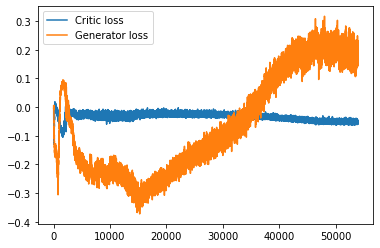

**** Iter 54000  Val ROC 0.940, AP: 0.936, EO 0.494 ****
55000  /200000   training iterations, took 18620 seconds so far...


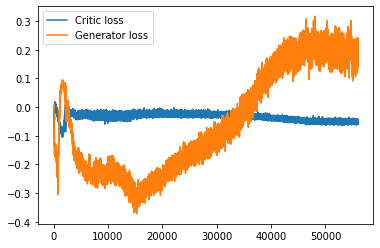

**** Iter 56000  Val ROC 0.940, AP: 0.936, EO 0.497 ****
57500  /200000   training iterations, took 19460 seconds so far...


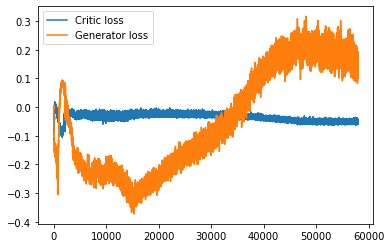

**** Iter 58000  Val ROC 0.940, AP: 0.935, EO 0.505 ****


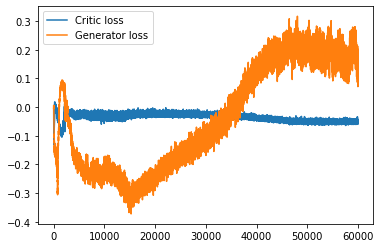

60000  /200000   training iterations, took 20307 seconds so far...
**** Iter 60000  Val ROC 0.943, AP: 0.938, EO 0.505 ****


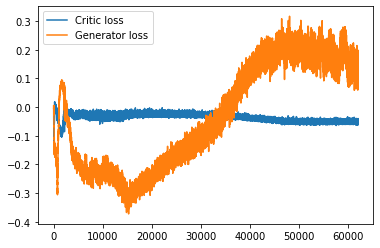

**** Iter 62000  Val ROC 0.939, AP: 0.934, EO 0.505 ****
62500  /200000   training iterations, took 21166 seconds so far...


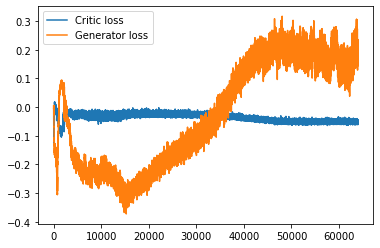

**** Iter 64000  Val ROC 0.941, AP: 0.936, EO 0.504 ****
65000  /200000   training iterations, took 22011 seconds so far...


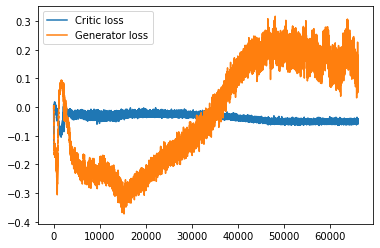

**** Iter 66000  Val ROC 0.941, AP: 0.936, EO 0.503 ****
67500  /200000   training iterations, took 22858 seconds so far...


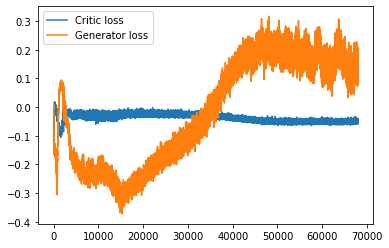

**** Iter 68000  Val ROC 0.941, AP: 0.936, EO 0.511 ****


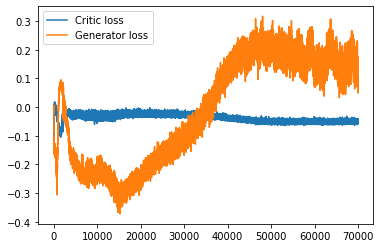

70000  /200000   training iterations, took 23705 seconds so far...
**** Iter 70000  Val ROC 0.942, AP: 0.937, EO 0.507 ****


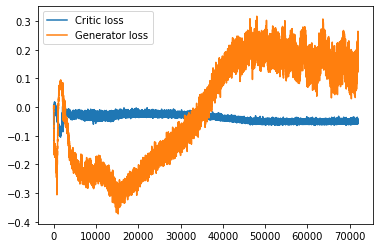

**** Iter 72000  Val ROC 0.942, AP: 0.938, EO 0.513 ****
72500  /200000   training iterations, took 24564 seconds so far...


In [ ]:
train_to_eo_and_save_models(target_eo=.52,
                            num_models=5,
                            dataset=dataset,
                            train_graph=train_graph,
                            val_ones=val_ones,
                            val_zeros=val_zeros)

## Graph Generation

In [6]:
def get_model_path(dataset, target_eo, i, str_len):
    directory = os.path.join('../models',
                             dataset,
                             f'netgan_eo_{int(100*target_eo)}')
    return os.path.join(directory, f'model_{i:0{str_len}d}.ckpt')

In [8]:
def graphs_from_models(train_graph,
                       models_path,
                       graphs_path,
                       num_models,
                       val_ones,
                       val_zeros,
                       rw_len = 16,
                       batch_size = 128):
    walker = netgan.utils.RandomWalker(train_graph, rw_len=rw_len, p=1, q=1, batch_size=batch_size)
    # define model
    model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                          use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                          W_down_generator_size=128, l2_penalty_generator=1e-7,
                          l2_penalty_discriminator=5e-5, generator_layers=[40],
                          discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
    
    str_len = len(str(num_models-1))
    saver = tf.train.Saver()
    for i in range(num_models):
        saver.restore(model.session, os.path.join(models_path, f'model_{i:0{str_len}d}.ckpt'))
        sample_many = model.generate_discrete(10000, reuse=True, legacy=False)
        start = time.time()
        rws = netgan.utils.sample_rws(sampler=sample_many, sampler_args={model.tau: 0.5}, steps=6000)
        scores_matrix = netgan.utils.score_matrix_from_random_walks(rws, train_graph.shape[0])
        scores_matrix = scores_matrix.toarray()
        sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum()/2)
        timing = time.time() - start
        
        experiment_path = os.path.join(graphs_path, f'Experiment_{i:0{str_len}d}')
        sampled_graphs_path = os.path.join(experiment_path, 'sampled_graphs')
        scores_matrix_path = os.path.join(experiment_path, 'scores_matrix')
        Path(sampled_graphs_path).mkdir(parents=True, exist_ok=True)
        Path(scores_matrix_path).mkdir(parents=True, exist_ok=True)
        
        # save scores
        np.save(os.path.join(scores_matrix_path, 'scores_matrix_1'), scores_matrix)
        
        # save graph
        save_npz(file=os.path.join(sampled_graphs_path, 'graph_1'), matrix=sampled_graph)
        
        utils.save_dict({1: timing}, os.path.join(sampled_graphs_path, 'timing.pickle'))
        # compute eo:
        overlap = 2 * utils.edge_overlap(train_graph, sampled_graph) / train_graph.sum()
        utils.save_dict({1: overlap}, os.path.join(sampled_graphs_path, 'overlap.pickle'))
        # link prediction performance:
        roc_auc, avg_prec = utils.link_prediction_performance(scores_matrix, val_ones, val_zeros)
        utils.save_dict({1: roc_auc}, os.path.join(sampled_graphs_path, 'ROC-AUC.pickle'))
        utils.save_dict({1: avg_prec}, os.path.join(sampled_graphs_path, 'avg_prec.pickle'))

In [9]:
target_eo = .52
graphs_from_models(train_graph=train_graph,
                   models_path=os.path.join('../models',
                                            dataset,
                                            f'netgan_eo_{int(100*target_eo)}'),
                   graphs_path=os.path.join('../logs/',
                                            dataset,
                                            f'baseline_Netgan_sample_many_eo_{int(100*target_eo)}'),
                   num_models=5,
                   val_ones=test_ones,
                   val_zeros=test_zeros)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/rt_gop/netgan_eo_52/model_0.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


INFO:tensorflow:Restoring parameters from ../models/rt_gop/netgan_eo_52/model_1.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


INFO:tensorflow:Restoring parameters from ../models/rt_gop/netgan_eo_52/model_2.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


INFO:tensorflow:Restoring parameters from ../models/rt_gop/netgan_eo_52/model_3.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


INFO:tensorflow:Restoring parameters from ../models/rt_gop/netgan_eo_52/model_4.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [7]:
rw_len = 16
batch_size = 128
walker = netgan.utils.RandomWalker(train_graph, rw_len=rw_len, p=1, q=1, batch_size=batch_size)

In [8]:
model = netgan.NetGAN(_N, rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
saver = tf.train.Saver()

In [26]:
saver.restore(model.session, get_model_path(dataset, .52, 1, 1))

INFO:tensorflow:Restoring parameters from ../models/CORA_ML/netgan_eo_52/model_1.ckpt


In [18]:
sample_many = model.generate_discrete(10000, reuse=True, legacy=False)

In [20]:
rws = netgan.utils.sample_rws(sampler=sample_many, sampler_args={model.tau: 0.5}, steps=600)

500


In [21]:
scores_matrix = netgan.utils.score_matrix_from_random_walks(rws, _N)

In [22]:
scores_matrix = scores_matrix.toarray()

In [27]:
sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


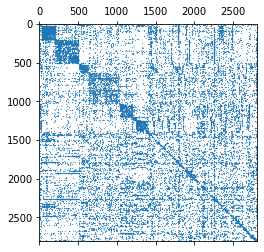

In [28]:
plt.spy(sampled_graph, markersize=.2)
plt.show()